<a href="https://colab.research.google.com/github/Ha-minss/Personal-Projects/blob/main/Ubiquant_Market_Prediction_preparing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub
from google.colab import files
import pandas as pd
import os, zipfile, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor

In [3]:
files.upload()  # 여기서 kaggle.json 파일 선택

Saving kaggle.json to kaggle (7).json


{'kaggle (7).json': b'{"username":"ehdgk0725","key":"efa68270d8926dcaeb86446184e814ea"}'}

In [4]:
# 1) ~/.kaggle 디렉토리 생성
!mkdir -p ~/.kaggle
# 2) 업로드된 kaggle.json을 이동
!cp kaggle.json ~/.kaggle/
# 3) 권한 설정 (안전하게 읽기 전용)
!chmod 600 ~/.kaggle/kaggle.json
# 4) Kaggle API 클라이언트 설치
!pip install -q kaggle

In [5]:
!kaggle datasets download \
    -d robikscube/ubiquant-parquet \
    -f train_low_mem.parquet \
    -p ./ubiquant-data \
    --unzip

Dataset URL: https://www.kaggle.com/datasets/robikscube/ubiquant-parquet
License(s): CC0-1.0
train_low_mem.parquet: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# ubiquant-data 내부 전체 폴더/파일 목록 확인
base_dir = './ubiquant-data'
for entry in os.listdir(base_dir):
    print(entry)

train_low_mem.parquet
train_low_mem.zip
train_low_mem_extracted


In [7]:
# 2) ZIP 파일 및 압축 해제 디렉터리 절대 경로 지정
zip_path     = '/content/ubiquant-data/train_low_mem.zip'
extract_dir  = '/content/ubiquant-data/train_low_mem_extracted'

# 3) 압축 해제
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_dir)
print(f"→ Extracted to: {extract_dir}")

# 4) 압축 해제된 디렉터리 내 Parquet 파일 찾기
parquet_files = glob.glob(os.path.join(extract_dir, '*.parquet'))
if not parquet_files:
    # 혹시 파티션 디렉터리 구조라면 재귀적으로 검색
    parquet_files = glob.glob(os.path.join(extract_dir, '**', '*.parquet'), recursive=True)
if not parquet_files:
    raise FileNotFoundError("압축 해제 디렉터리에 .parquet 파일이 없습니다!")

# 5) 첫 번째 Parquet 파일 로드
parquet_path = parquet_files[0]
print(f"→ Loading Parquet: {parquet_path}")
df = pd.read_parquet(parquet_path, engine='pyarrow')

# 6) 로드 확인
print("DataFrame shape:", df.shape)

→ Extracted to: /content/ubiquant-data/train_low_mem_extracted
→ Loading Parquet: /content/ubiquant-data/train_low_mem_extracted/train_low_mem.parquet
DataFrame shape: (3141410, 304)


In [8]:
#메모리사용량 감소시키기일
def reduce_mem_usage(df):
    import numpy as np
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == object:
            continue
        c_min, c_max = df[col].min(), df[col].max()
        if str(col_type).startswith('int'):
            for t in [np.int8, np.int16, np.int32, np.int64]:
                if c_min >= np.iinfo(t).min and c_max <= np.iinfo(t).max:
                    df[col] = df[col].astype(t); break
        else:
            # float
            if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            else:
                df[col] = df[col].astype(np.float32)
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory: {start_mem:.1f} → {end_mem:.1f} MB")
    return df

df = reduce_mem_usage(df)
print(df.memory_usage().sum() / 1024**2, "MB after downcast")

Memory: 3643.0 → 1839.5 MB
1839.471694946289 MB after downcast


In [9]:
# 컬럼명 확인
df.columns.tolist()

['row_id',
 'time_id',
 'investment_id',
 'target',
 'f_0',
 'f_1',
 'f_2',
 'f_3',
 'f_4',
 'f_5',
 'f_6',
 'f_7',
 'f_8',
 'f_9',
 'f_10',
 'f_11',
 'f_12',
 'f_13',
 'f_14',
 'f_15',
 'f_16',
 'f_17',
 'f_18',
 'f_19',
 'f_20',
 'f_21',
 'f_22',
 'f_23',
 'f_24',
 'f_25',
 'f_26',
 'f_27',
 'f_28',
 'f_29',
 'f_30',
 'f_31',
 'f_32',
 'f_33',
 'f_34',
 'f_35',
 'f_36',
 'f_37',
 'f_38',
 'f_39',
 'f_40',
 'f_41',
 'f_42',
 'f_43',
 'f_44',
 'f_45',
 'f_46',
 'f_47',
 'f_48',
 'f_49',
 'f_50',
 'f_51',
 'f_52',
 'f_53',
 'f_54',
 'f_55',
 'f_56',
 'f_57',
 'f_58',
 'f_59',
 'f_60',
 'f_61',
 'f_62',
 'f_63',
 'f_64',
 'f_65',
 'f_66',
 'f_67',
 'f_68',
 'f_69',
 'f_70',
 'f_71',
 'f_72',
 'f_73',
 'f_74',
 'f_75',
 'f_76',
 'f_77',
 'f_78',
 'f_79',
 'f_80',
 'f_81',
 'f_82',
 'f_83',
 'f_84',
 'f_85',
 'f_86',
 'f_87',
 'f_88',
 'f_89',
 'f_90',
 'f_91',
 'f_92',
 'f_93',
 'f_94',
 'f_95',
 'f_96',
 'f_97',
 'f_98',
 'f_99',
 'f_100',
 'f_101',
 'f_102',
 'f_103',
 'f_104',
 'f_105'

In [10]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0.0,1.0,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,0_2,0.0,2.0,-0.231079,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,0_6,0.0,6.0,0.568848,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,0_7,0.0,7.0,-1.064453,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,0_8,0.0,8.0,-0.531738,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


In [11]:
#결측치체크
print(sum(df.isnull().sum()))

0


In [12]:
#샘플만들기
df_sample = df.sample(n=100000, random_state = 42).reset_index(drop=True)

#피쳐리스트
all_feats = [f'f_{i}' for i in range(300)]

#30개씩분할
chunk_size =30
chunks = [all_feats[i:i+chunk_size] for i in range(0, len(all_feats), chunk_size)]

for idx, feats in enumerate(chunks, start=1):
    print(f"\n=== Chunk {idx}: features {feats[0]} ~ {feats[-1]} ===\n")

    sub = df_sample[feats + ['target']]

    # target과의 상관관계
    corrs = sub.corr()['target'].sort_values(ascending=False)
    print("■ Corr with target:\n", corrs, "\n")




=== Chunk 1: features f_0 ~ f_29 ===

■ Corr with target:
 target    1.000000
f_17      0.030996
f_5       0.028674
f_2       0.024758
f_8       0.022255
f_29      0.021903
f_26      0.021250
f_22      0.019646
f_11      0.015701
f_18      0.012752
f_12      0.010558
f_10      0.009231
f_0       0.007186
f_20      0.001964
f_27      0.001627
f_7      -0.001121
f_13     -0.006369
f_4      -0.008505
f_24     -0.012131
f_19     -0.012430
f_28     -0.015517
f_14     -0.016705
f_6      -0.019164
f_9      -0.022479
f_1      -0.022735
f_23     -0.025688
f_3      -0.031924
f_16     -0.032884
f_21     -0.036520
f_25     -0.043178
f_15     -0.043979
Name: target, dtype: float64 


=== Chunk 2: features f_30 ~ f_59 ===

■ Corr with target:
 target    1.000000
f_33      0.033481
f_37      0.017395
f_32      0.016888
f_34      0.014612
f_56      0.004268
f_30     -0.002240
f_49     -0.004917
f_39     -0.009136
f_35     -0.009464
f_40     -0.011069
f_57     -0.011610
f_38     -0.013076
f_53     -0.

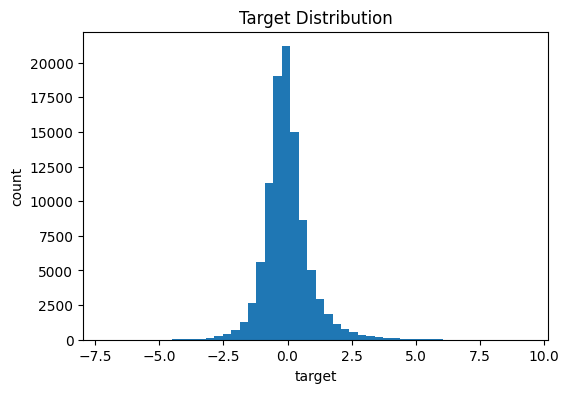

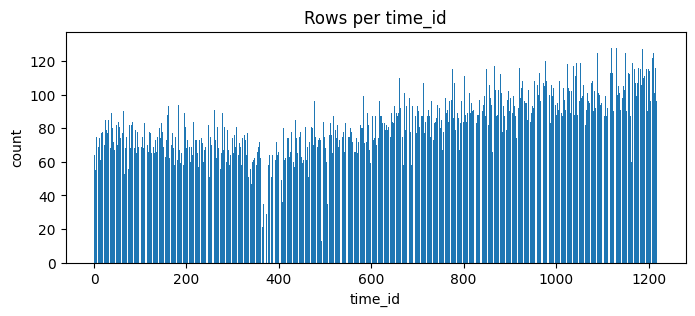

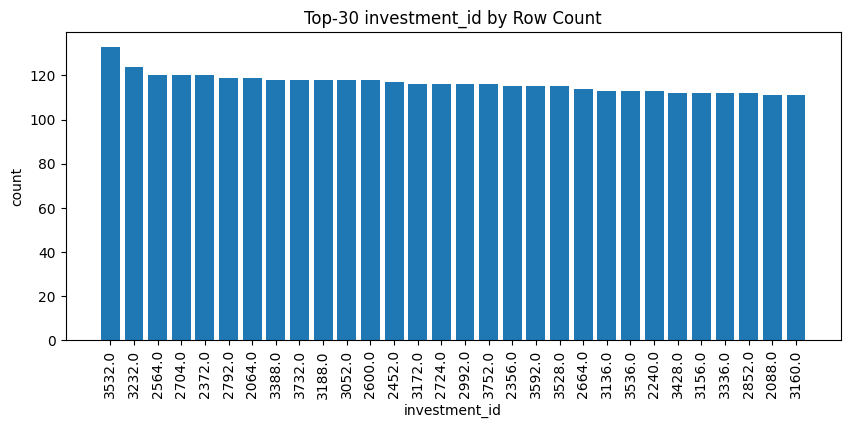

In [13]:
# 1) target 히스토그램
plt.figure(figsize=(6,4))
plt.hist(df_sample['target'], bins=50)
plt.title('Target Distribution')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

# 2) time_id 분포 (시간별 row 수)
plt.figure(figsize=(8,3))
time_counts = df_sample['time_id'].value_counts().sort_index()
plt.bar(time_counts.index, time_counts.values, width=0.8)
plt.title('Rows per time_id')
plt.xlabel('time_id')
plt.ylabel('count')
plt.show()

# 3) investment_id 빈도 상위 30개만
top_inv = df_sample['investment_id'].value_counts().head(30)
plt.figure(figsize=(10,4))
plt.bar(top_inv.index.astype(str), top_inv.values)
plt.title('Top-30 investment_id by Row Count')
plt.xlabel('investment_id')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

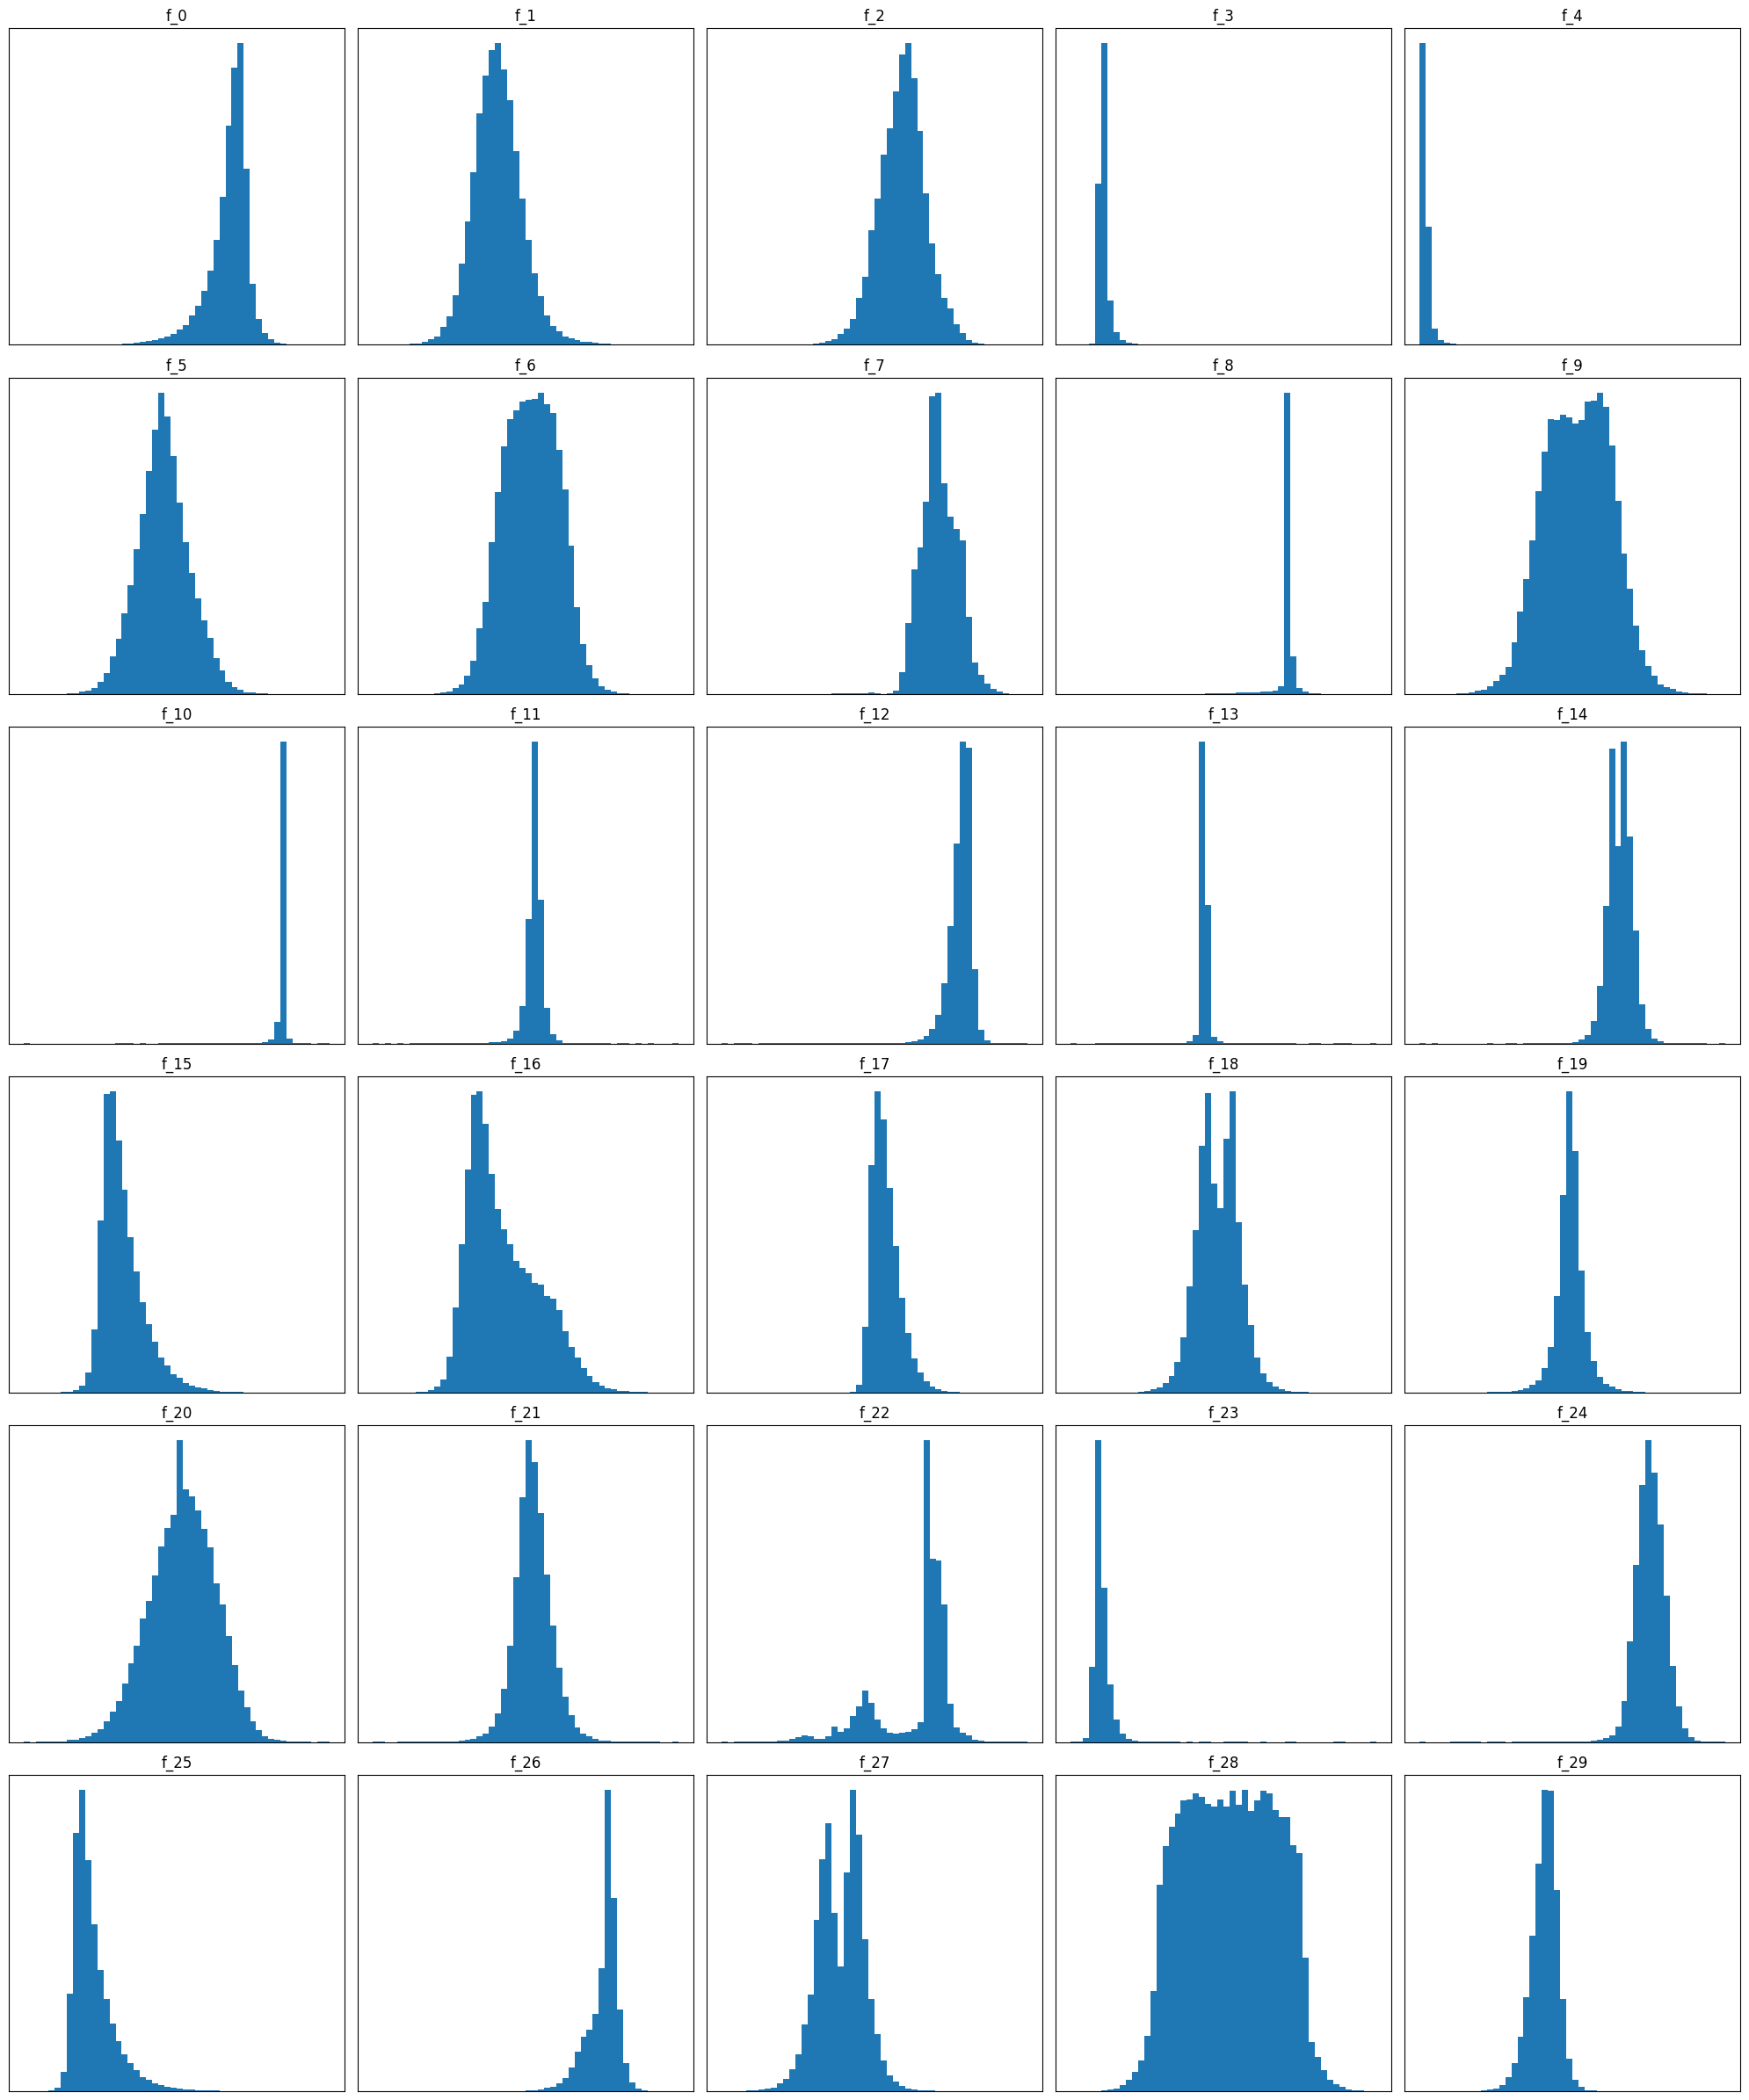

In [14]:
def plot_feature_chunk(df, all_feats, chunk_idx, chunk_size=30):
    chunk_feats = all_feats[chunk_idx * chunk_size : (chunk_idx + 1) * chunk_size]
    fig, axes = plt.subplots(6, 5, figsize=(20,24))
    axes = axes.flatten()
    for ax, feat in zip(axes, chunk_feats):
        ax.hist(df[feat].dropna(), bins=50)
        ax.set_title(feat)
        ax.set_xticks([]); ax.set_yticks([])
    for ax in axes[len(chunk_feats):]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
#1~30번째
plot_feature_chunk(df_sample, all_feats, chunk_idx=0)

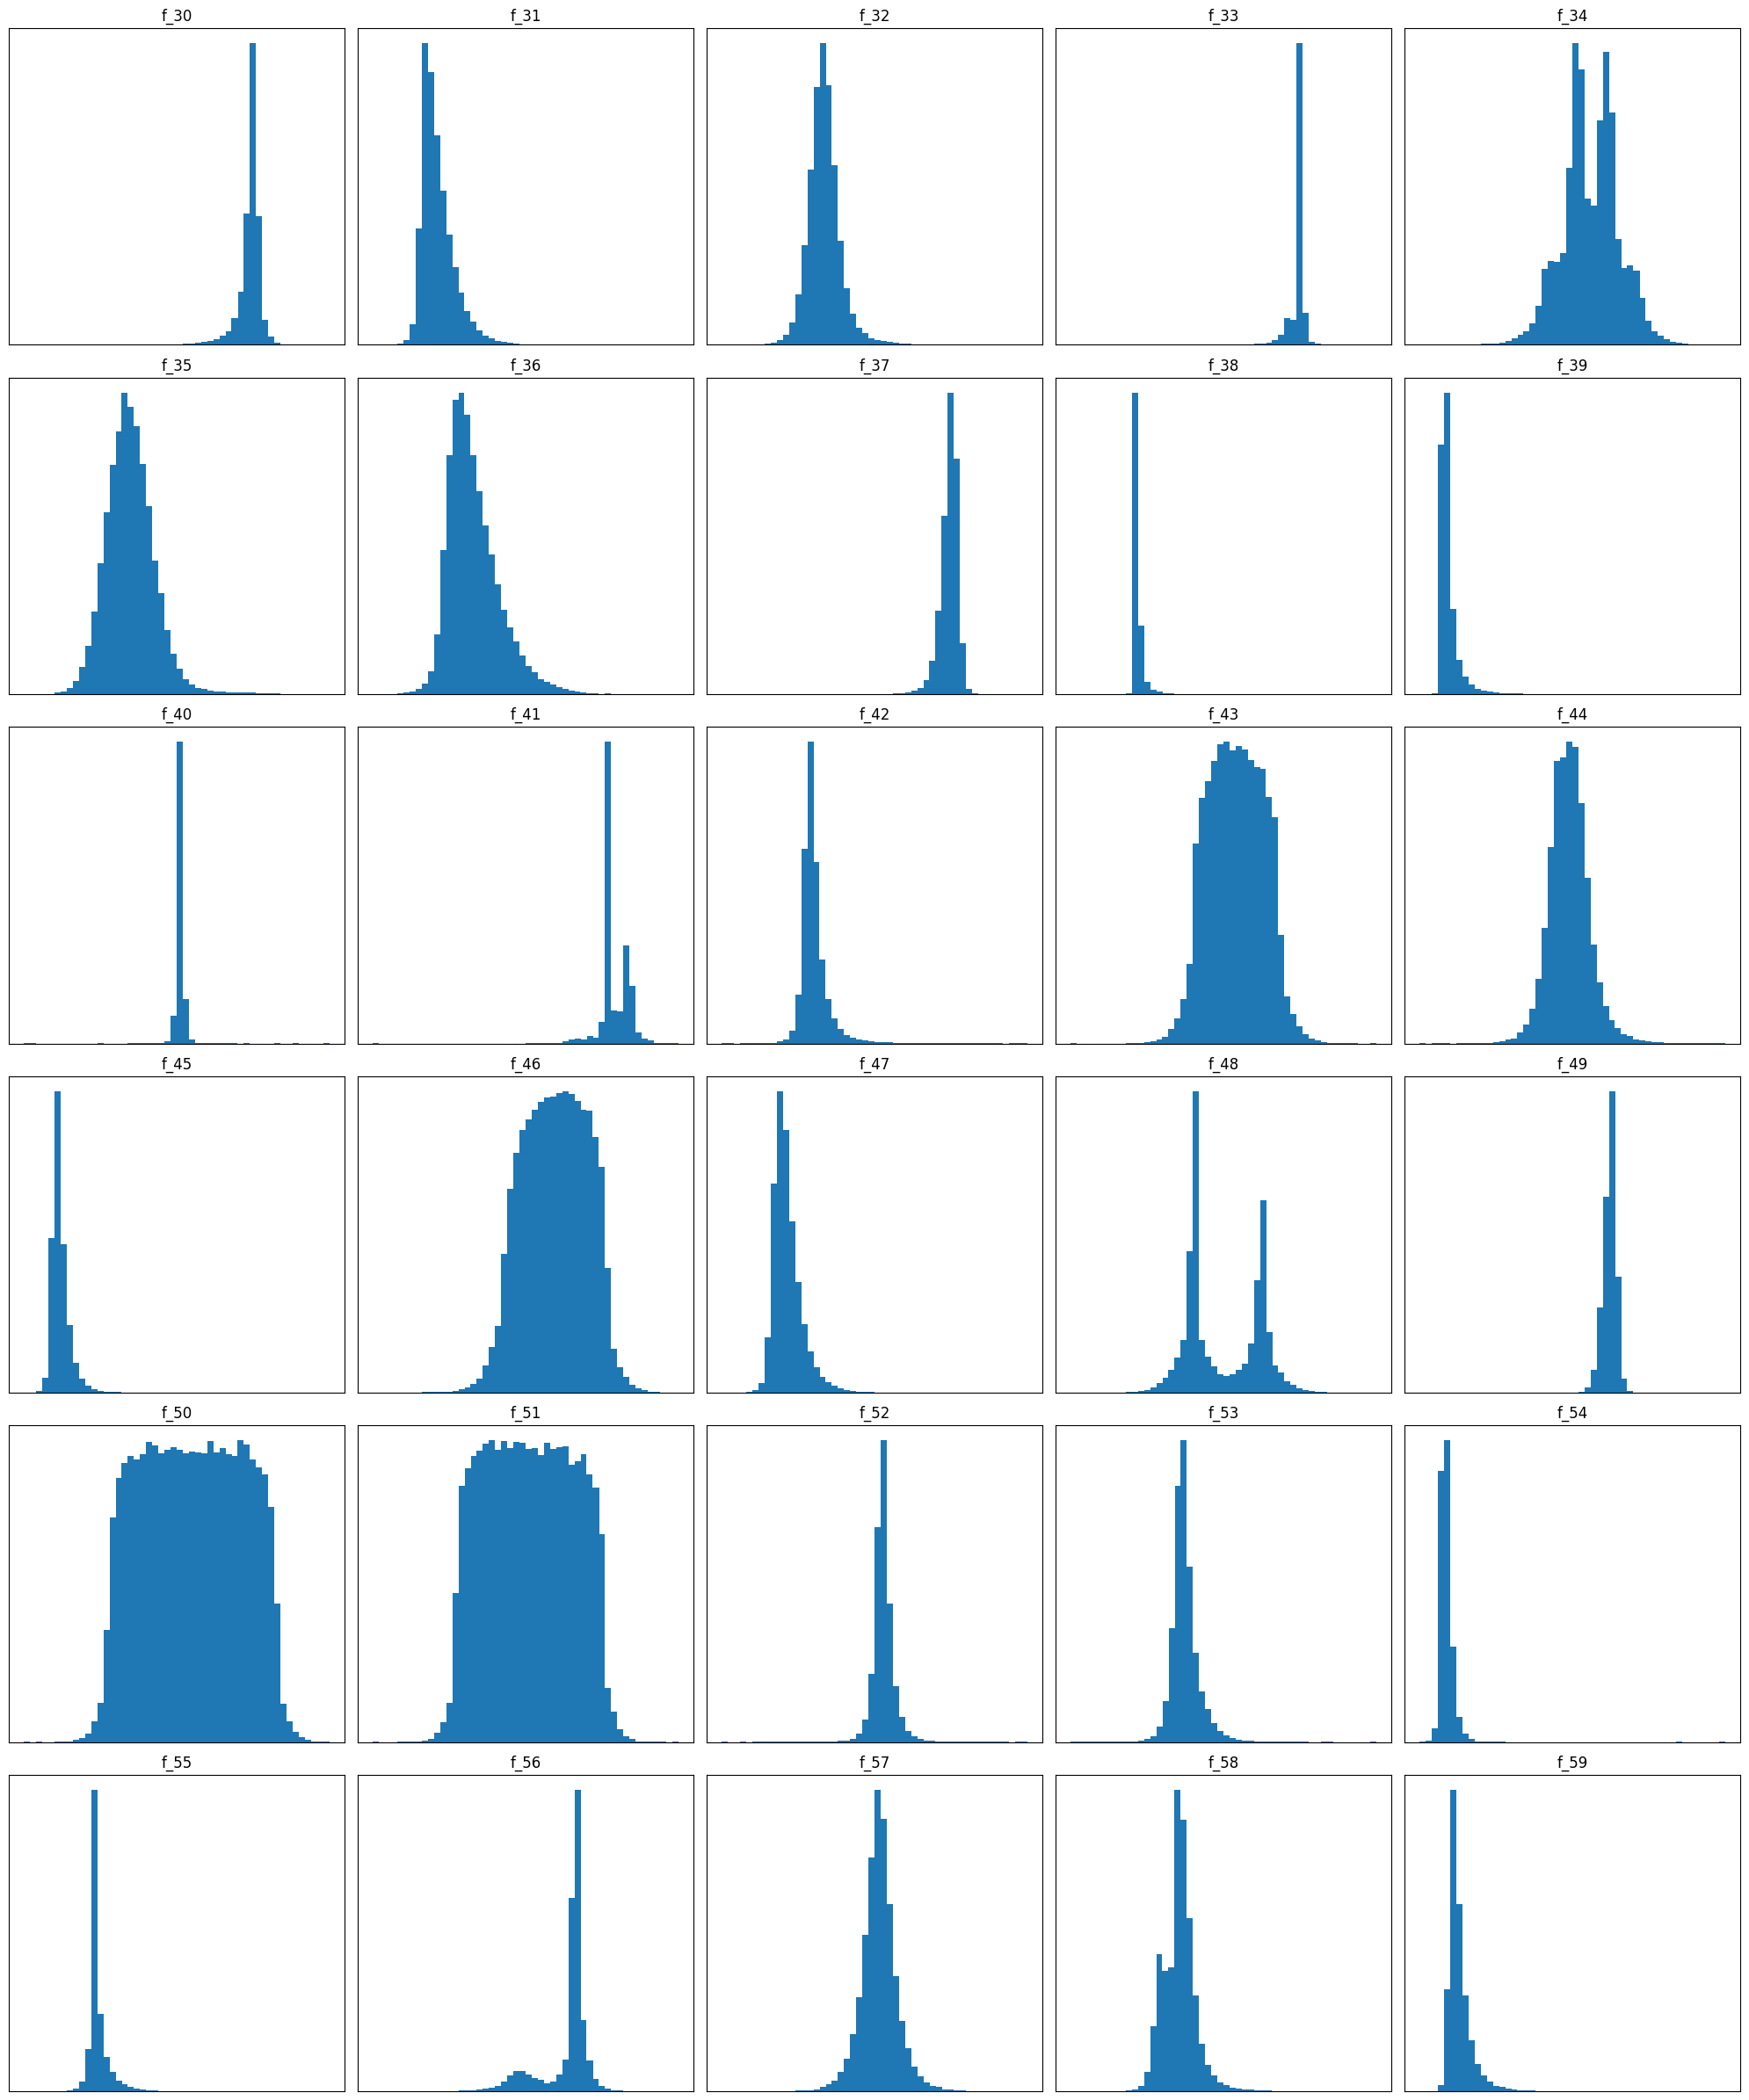

In [15]:
#31~60번째
plot_feature_chunk(df_sample, all_feats, chunk_idx=1)

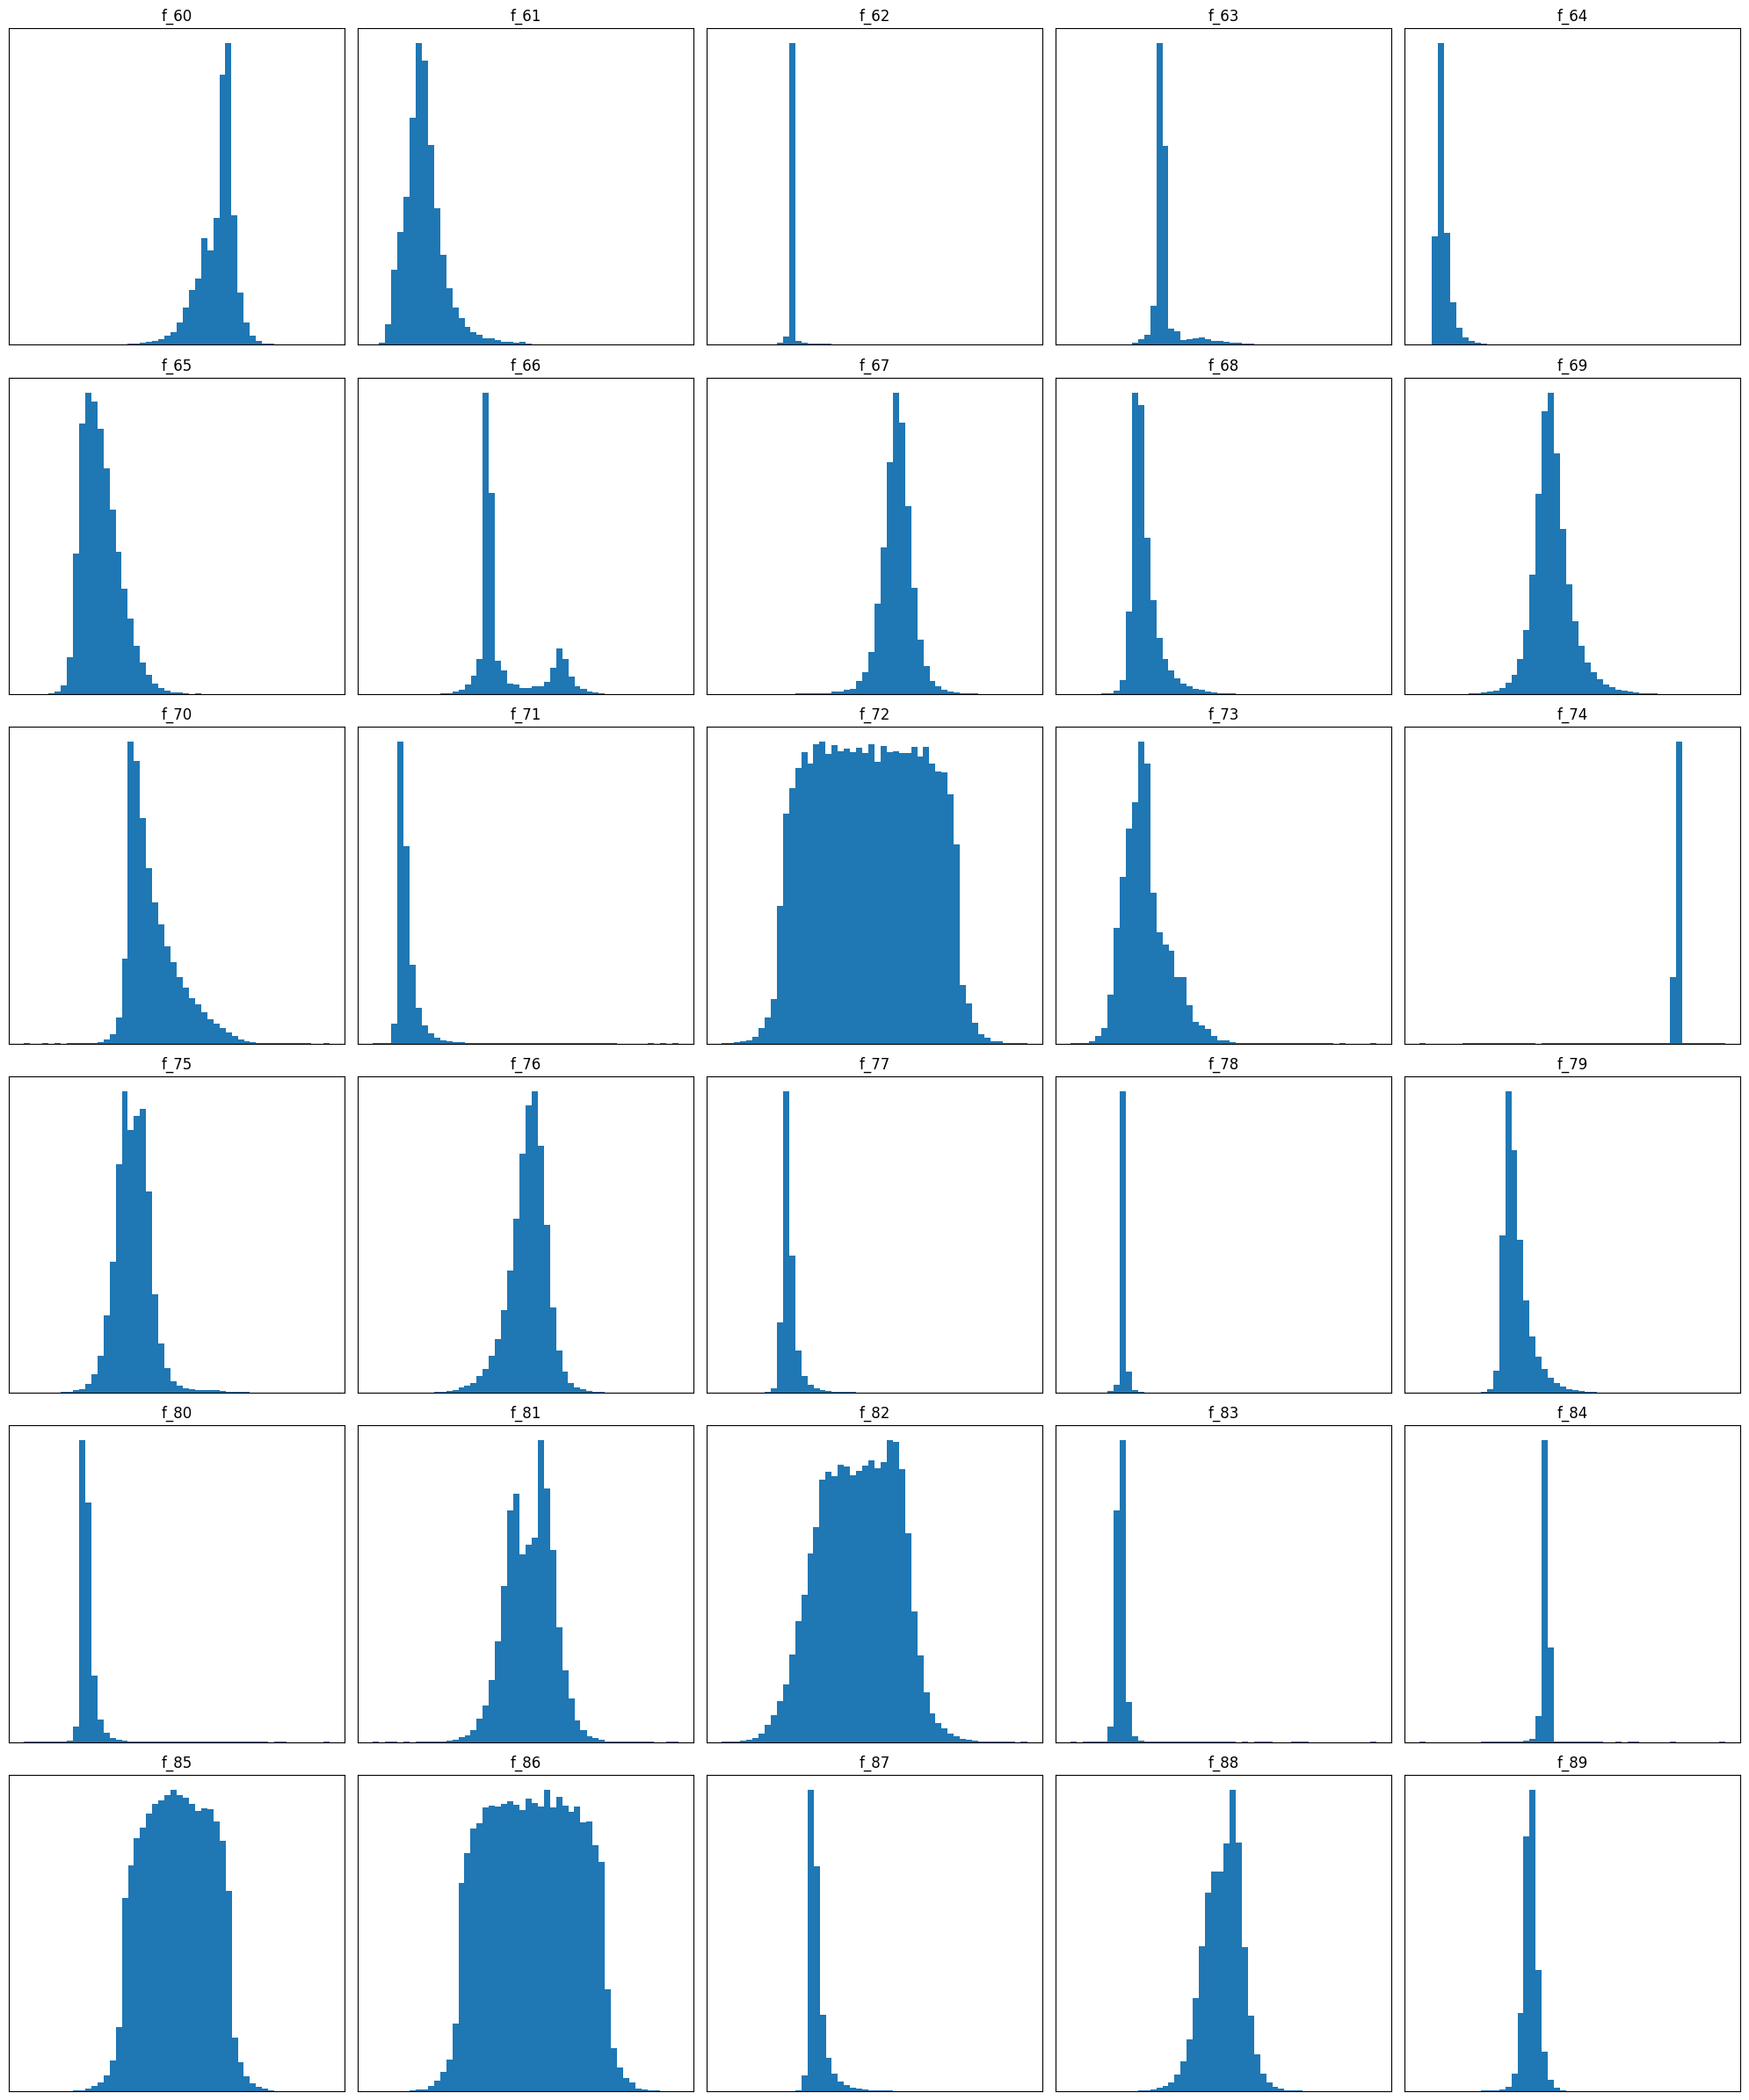

In [16]:
#61~90번째
plot_feature_chunk(df_sample, all_feats, chunk_idx=2)

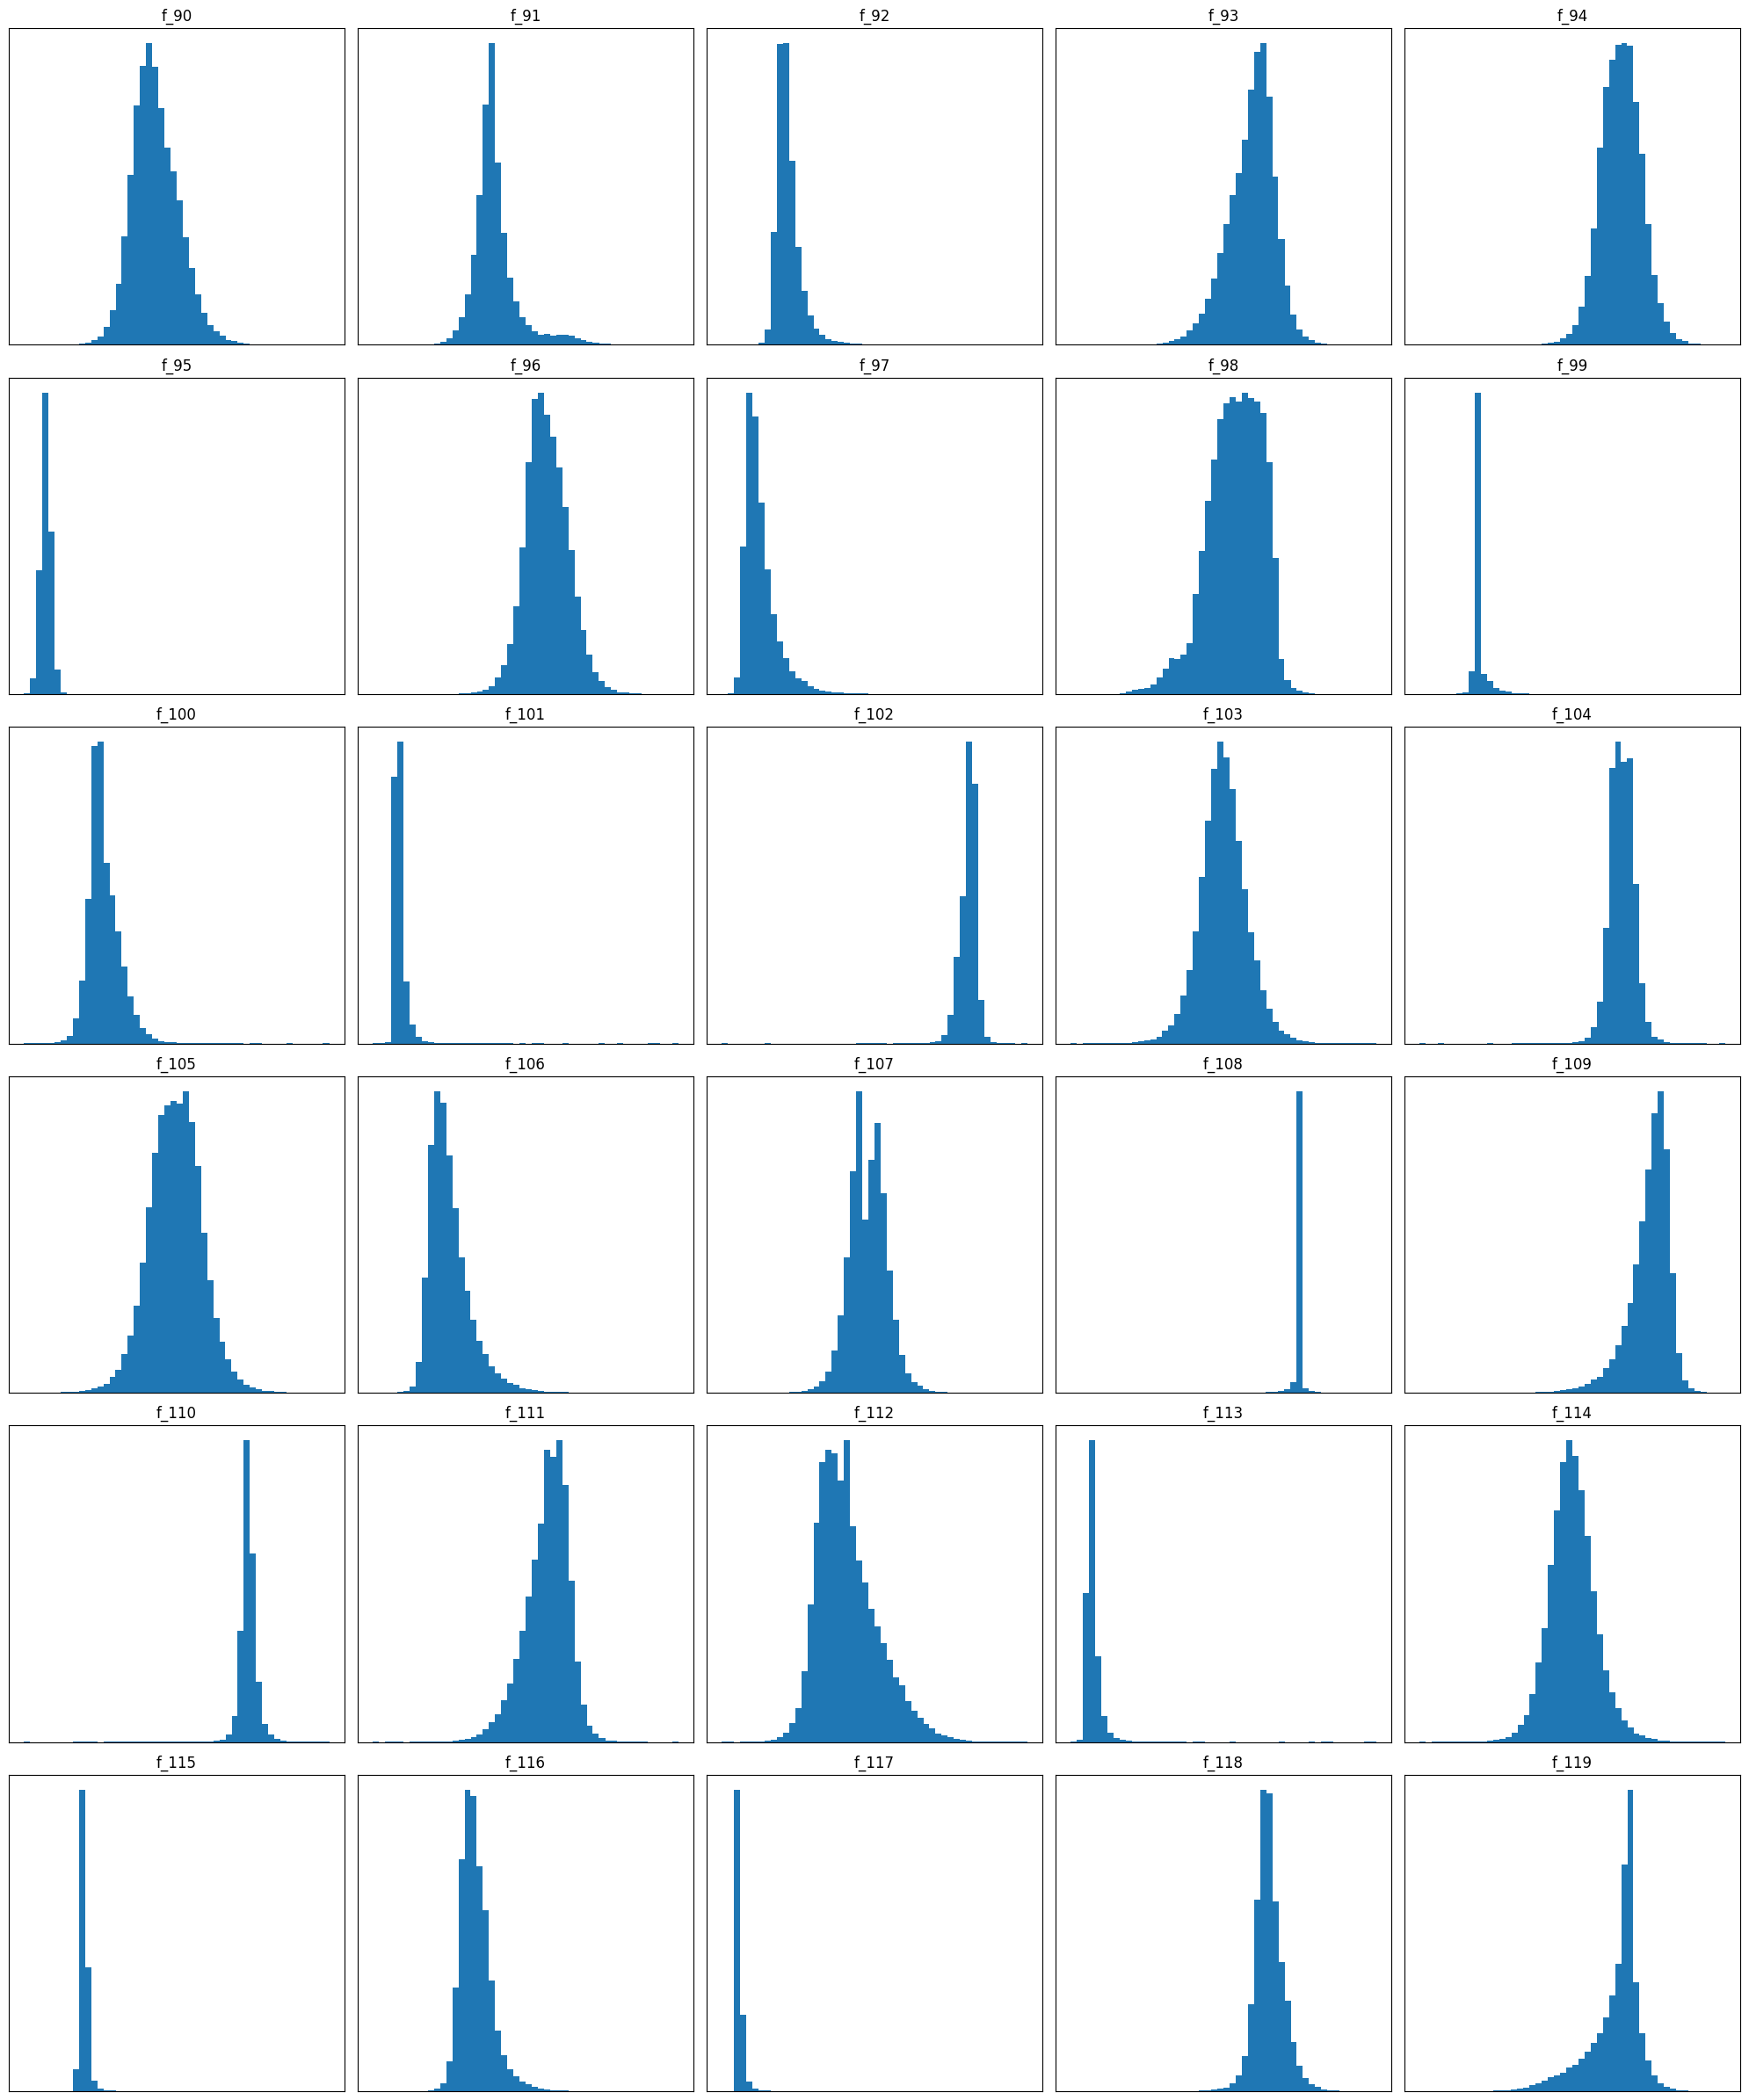

In [17]:
#91~120번째
plot_feature_chunk(df_sample, all_feats, chunk_idx=3)

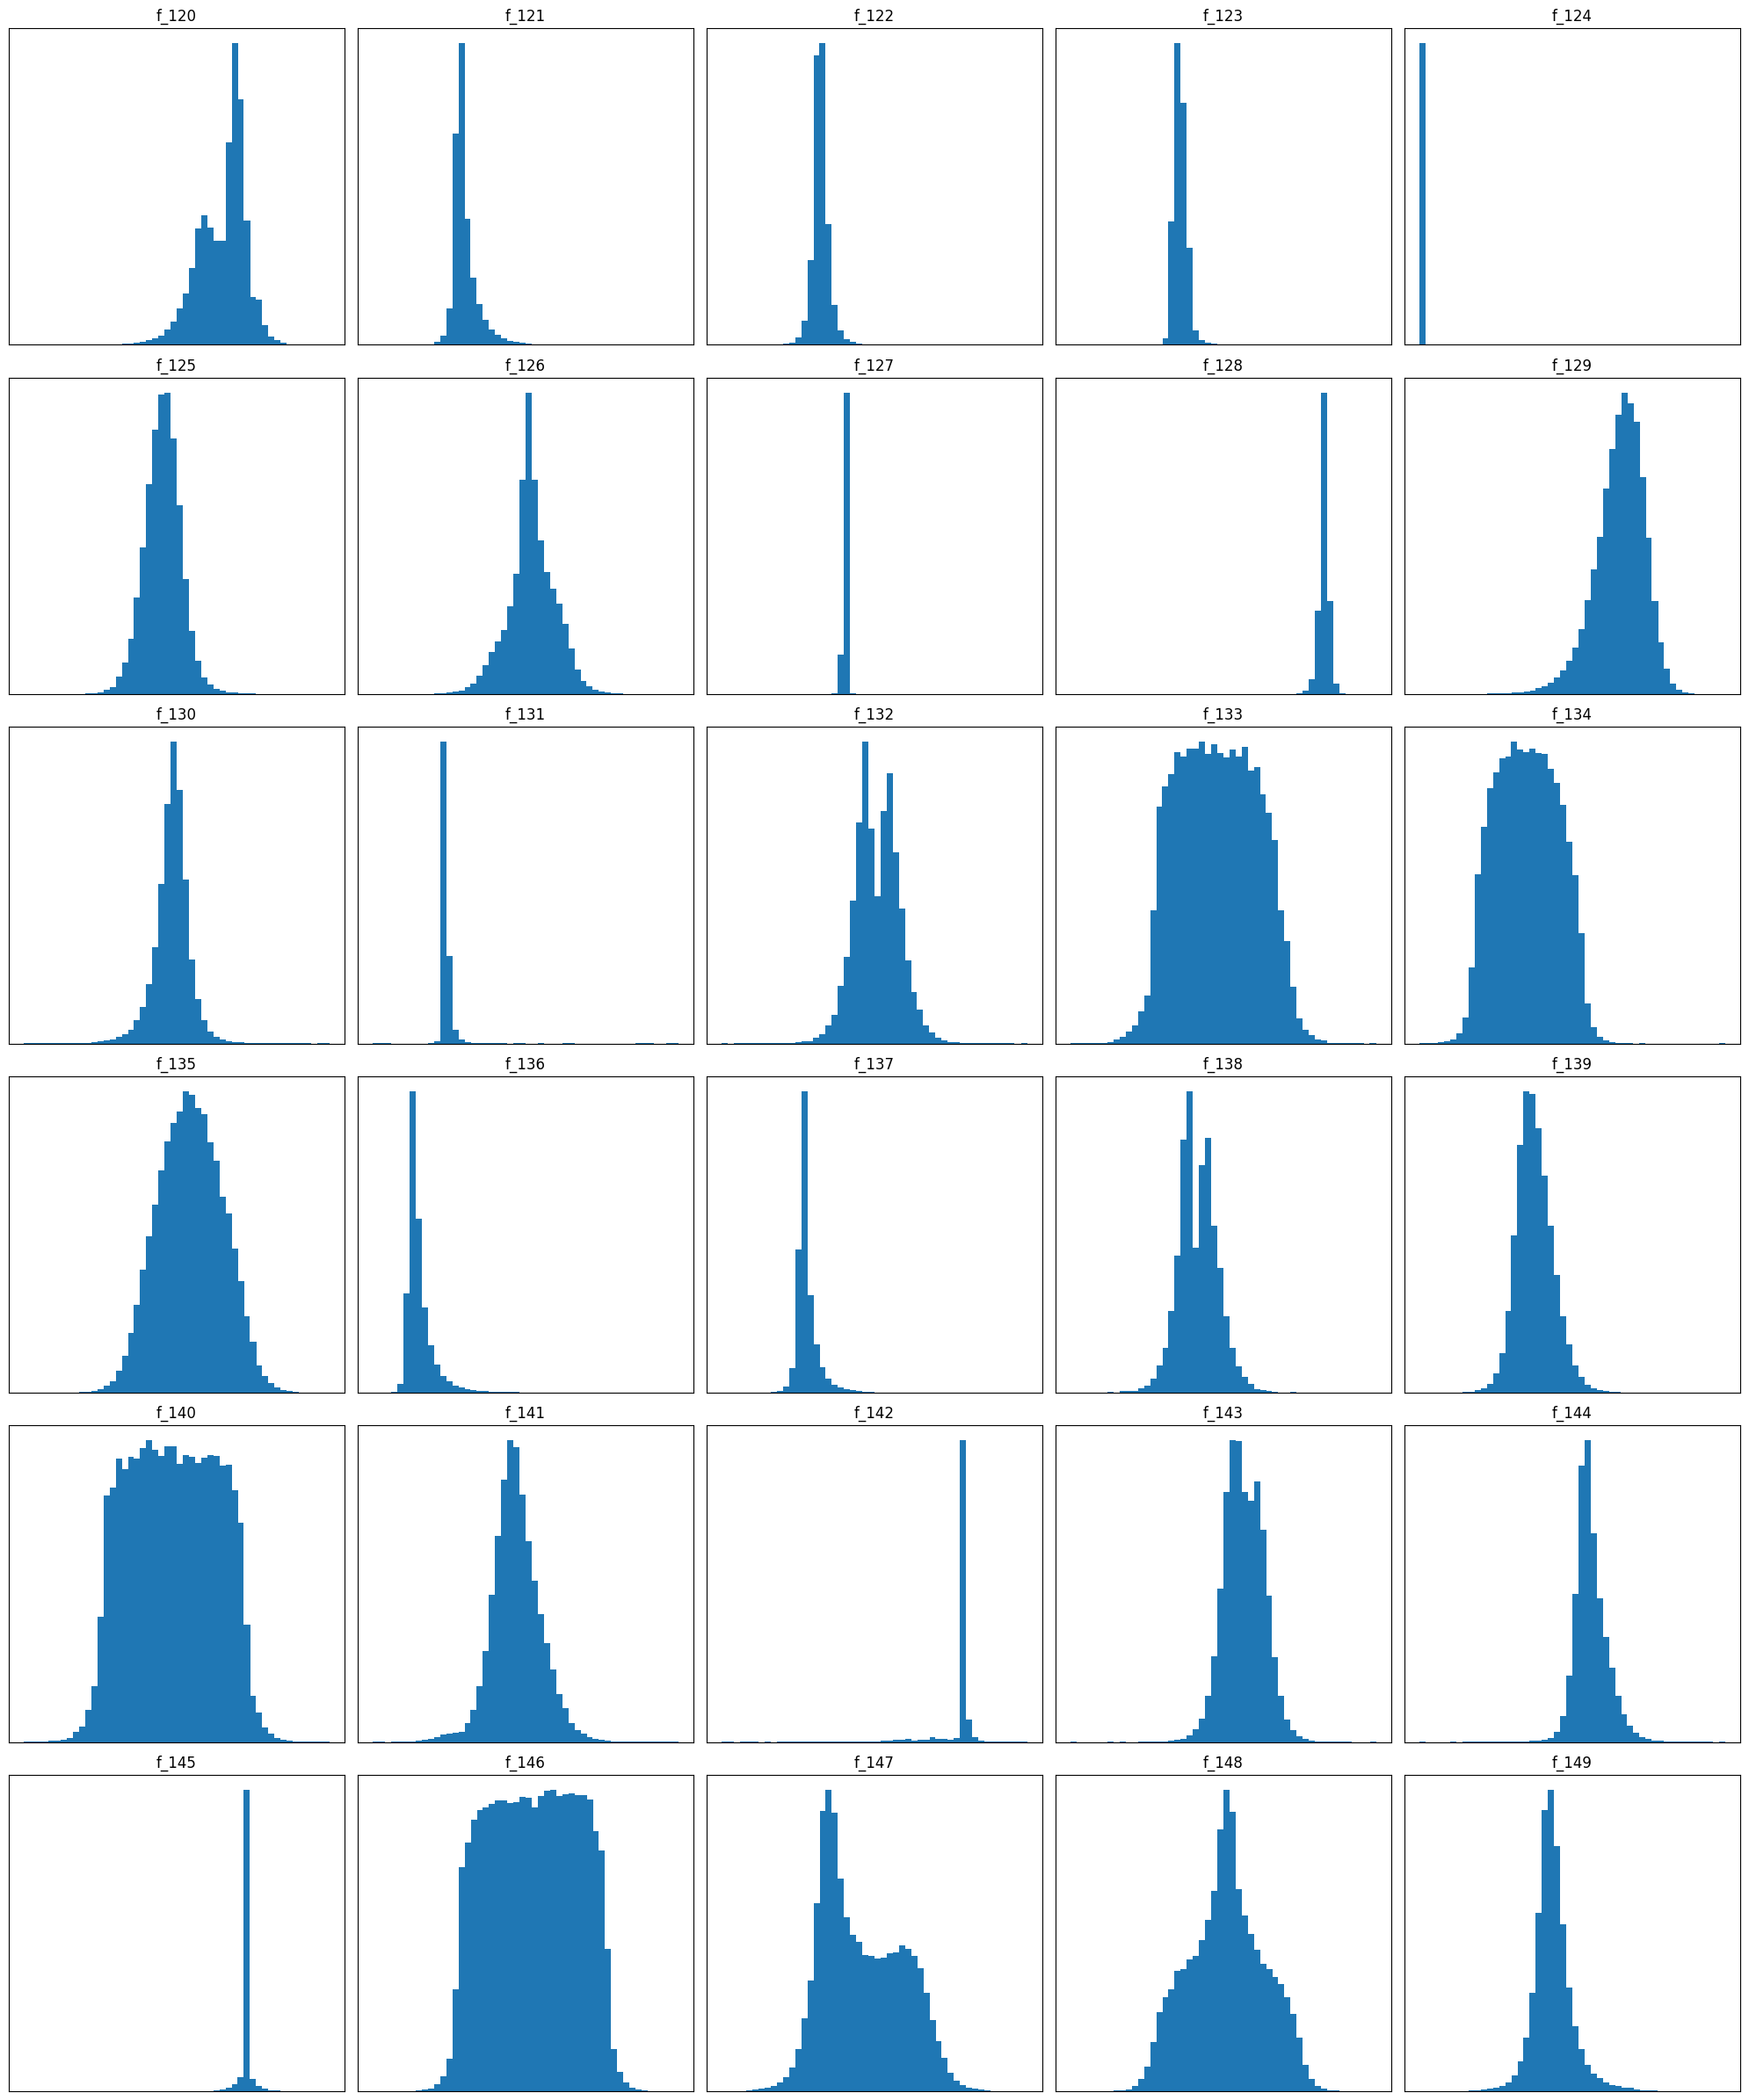

In [18]:
#121~150번째
plot_feature_chunk(df_sample, all_feats, chunk_idx=4)

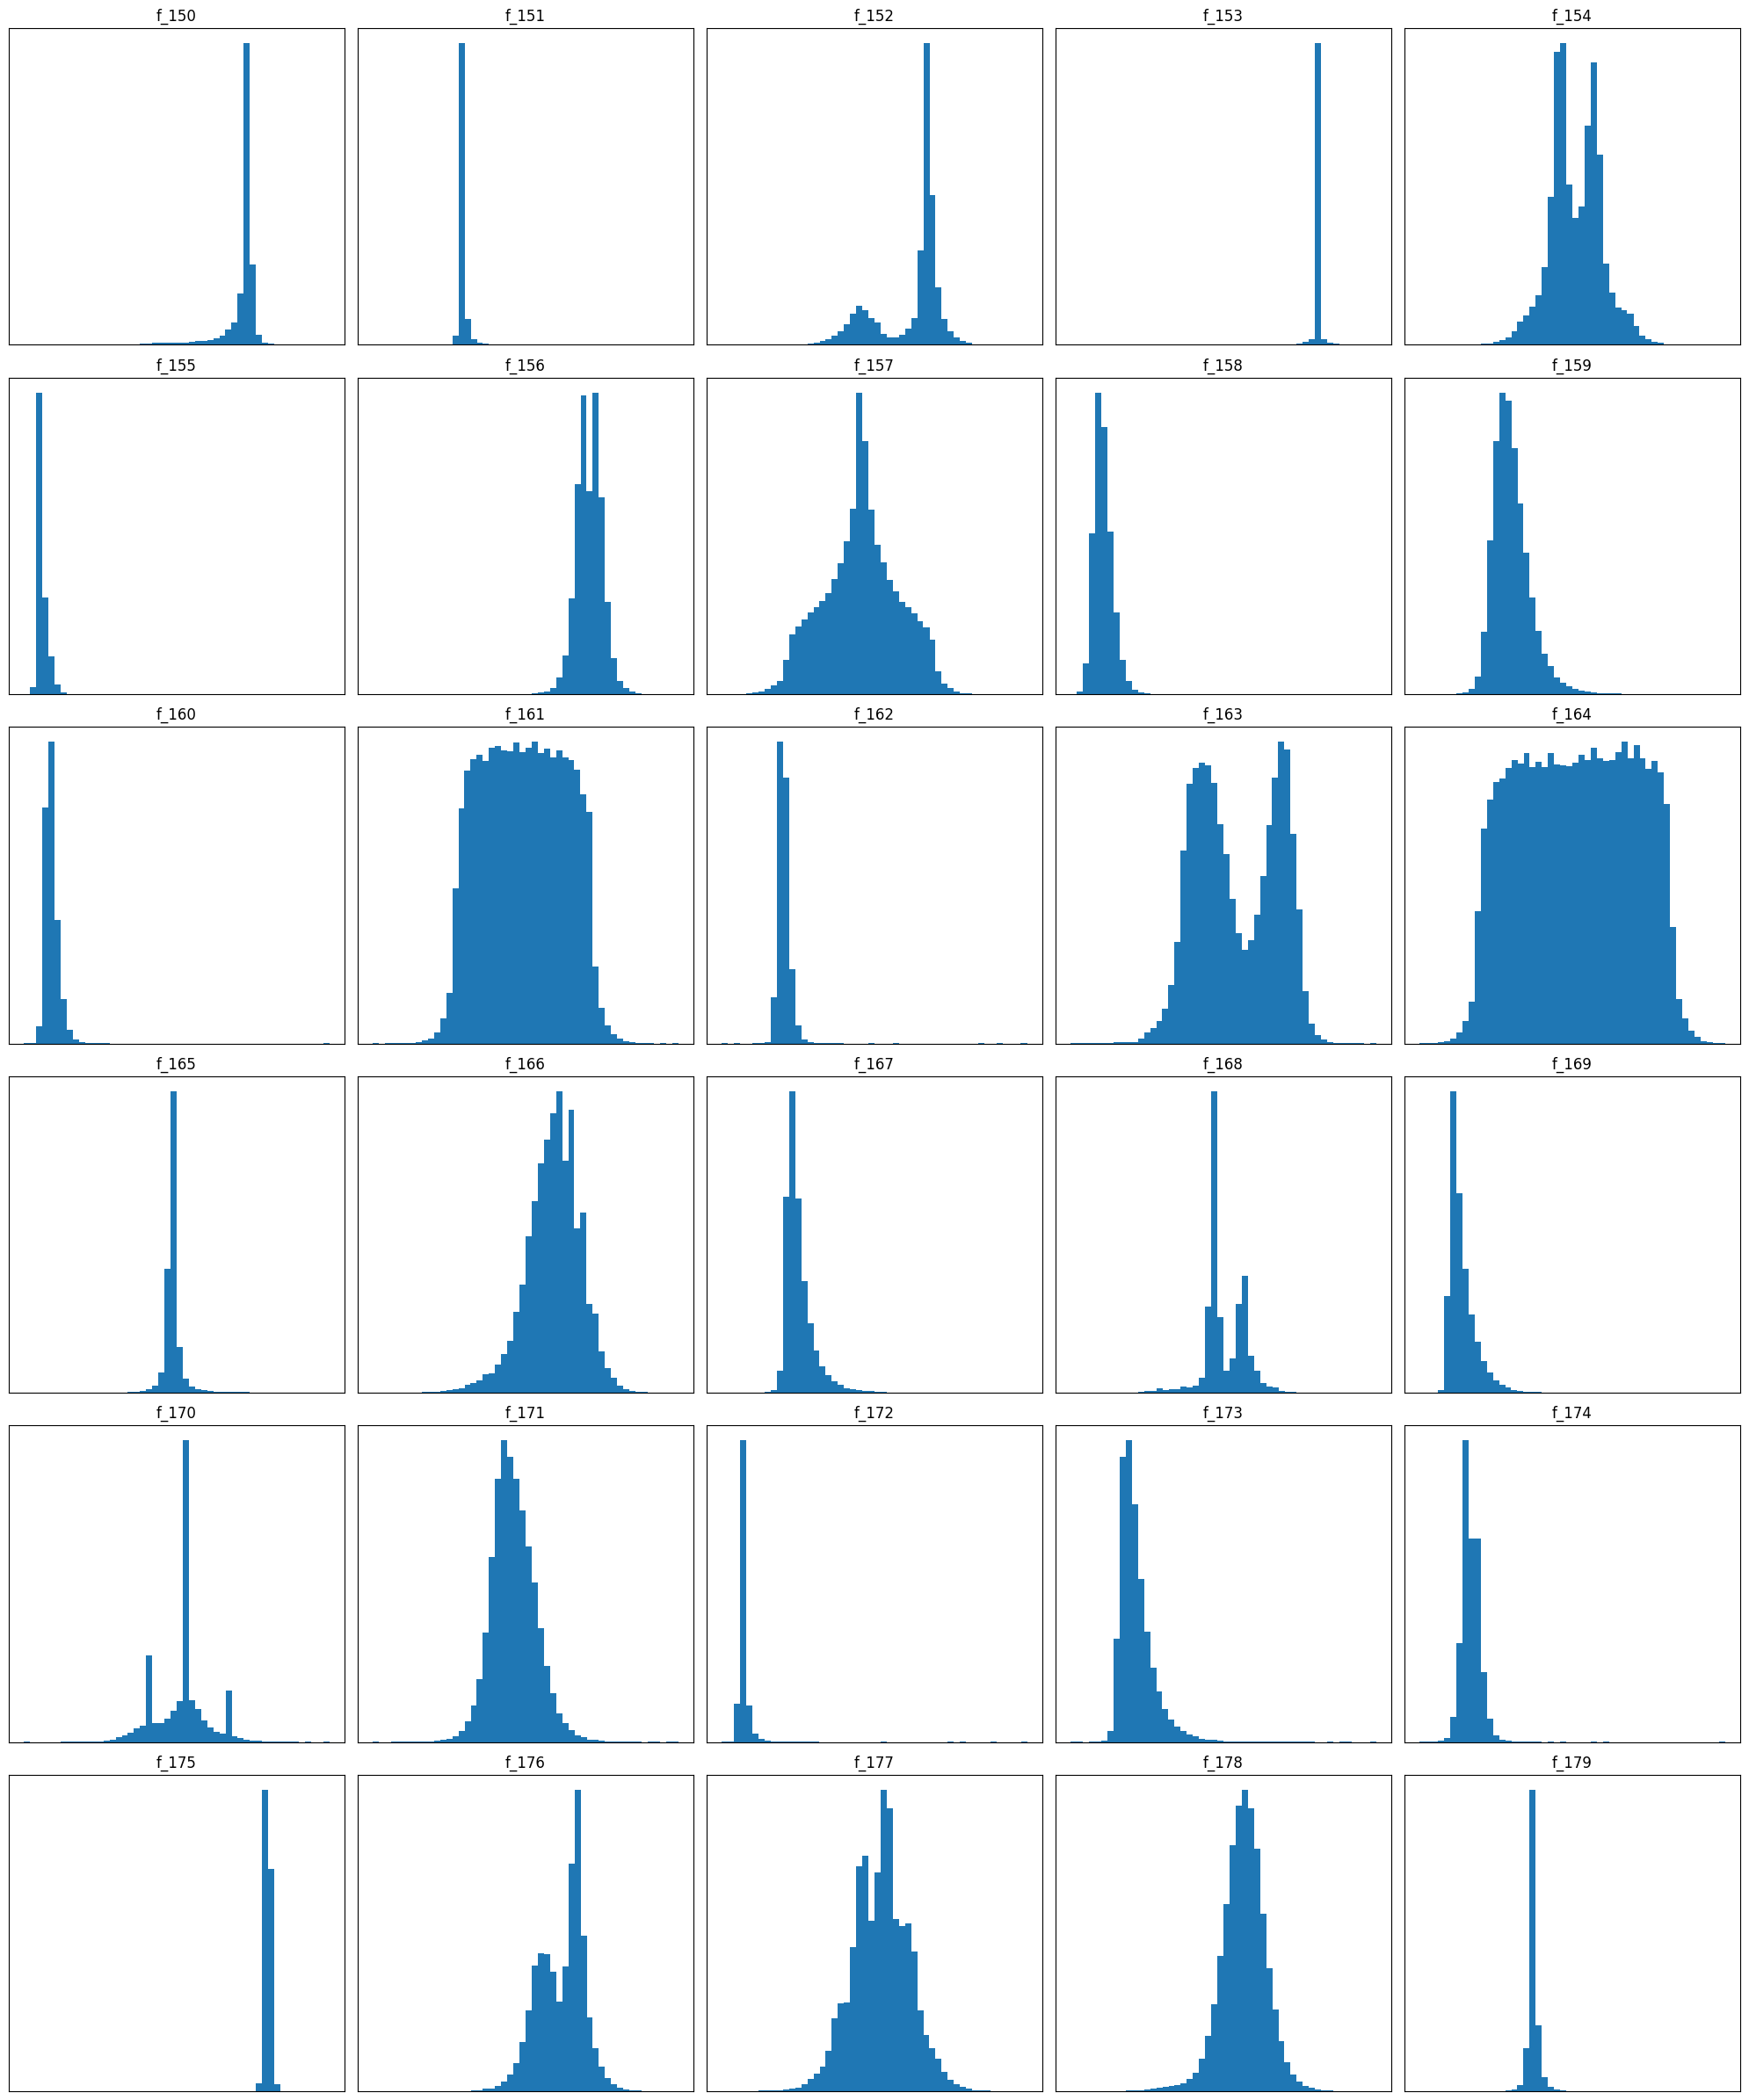

In [19]:
#151~180번째
plot_feature_chunk(df_sample, all_feats, chunk_idx=5)

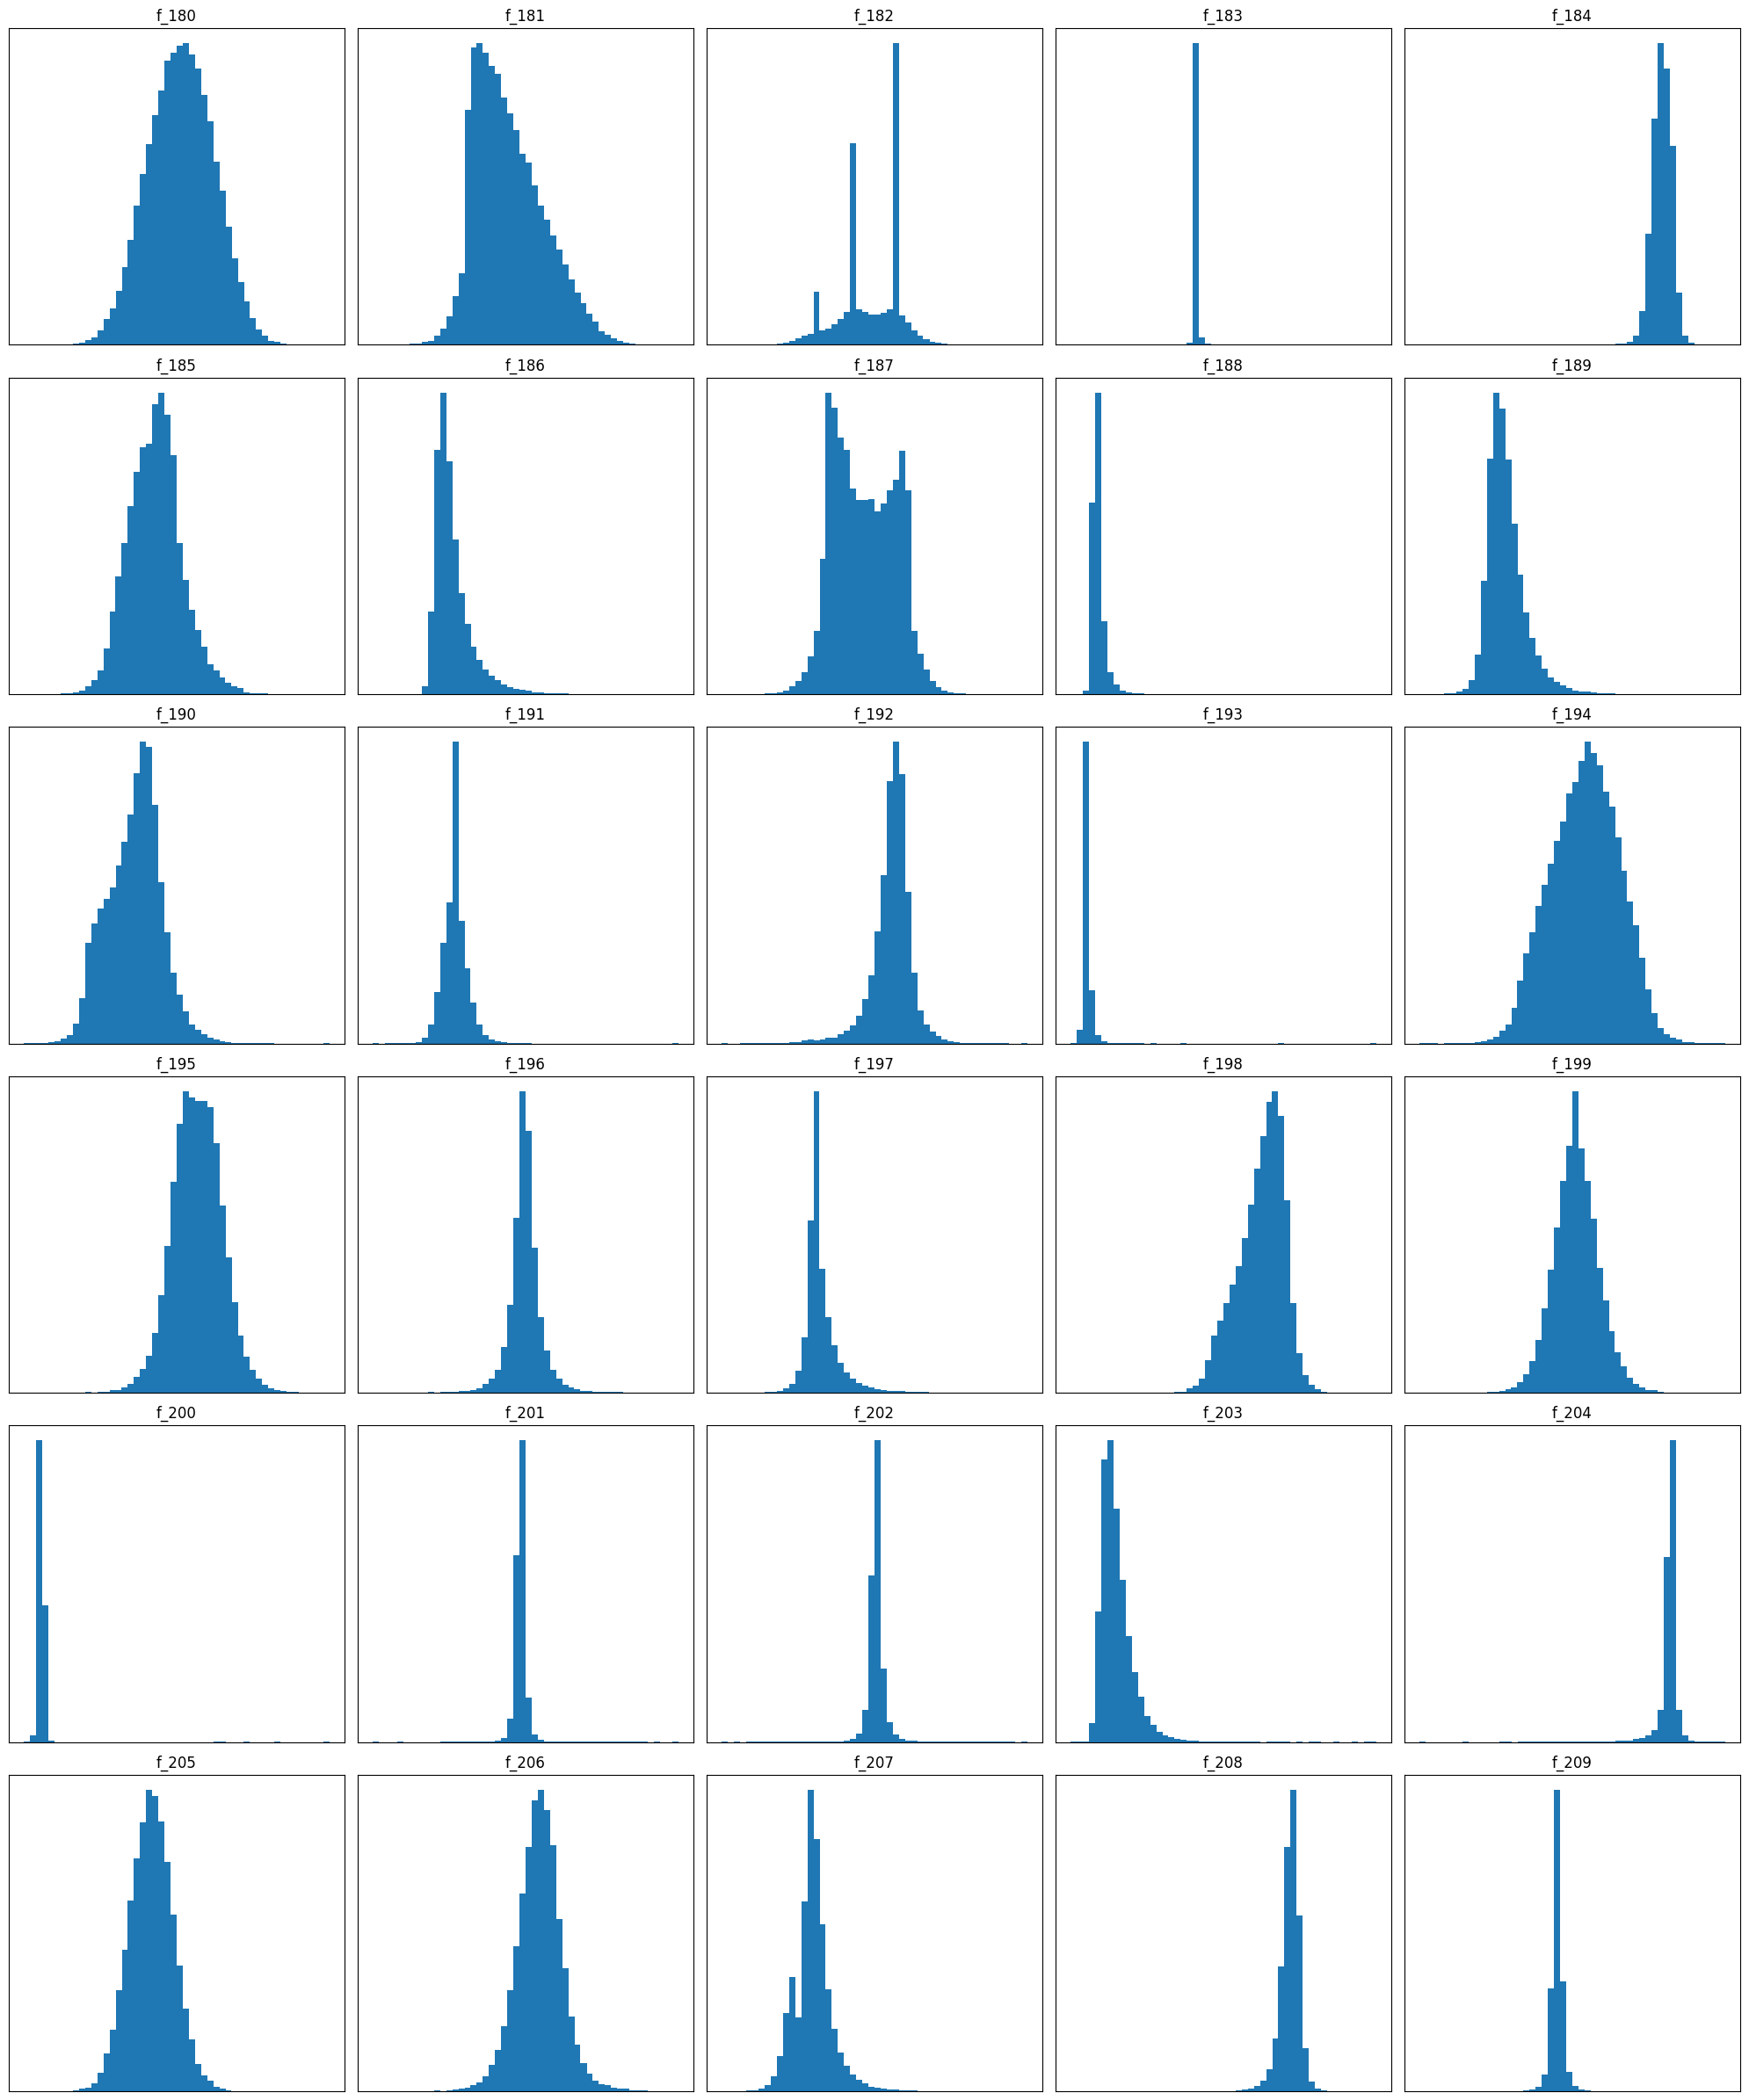

In [20]:
#181~210번째
plot_feature_chunk(df_sample, all_feats, chunk_idx=6)

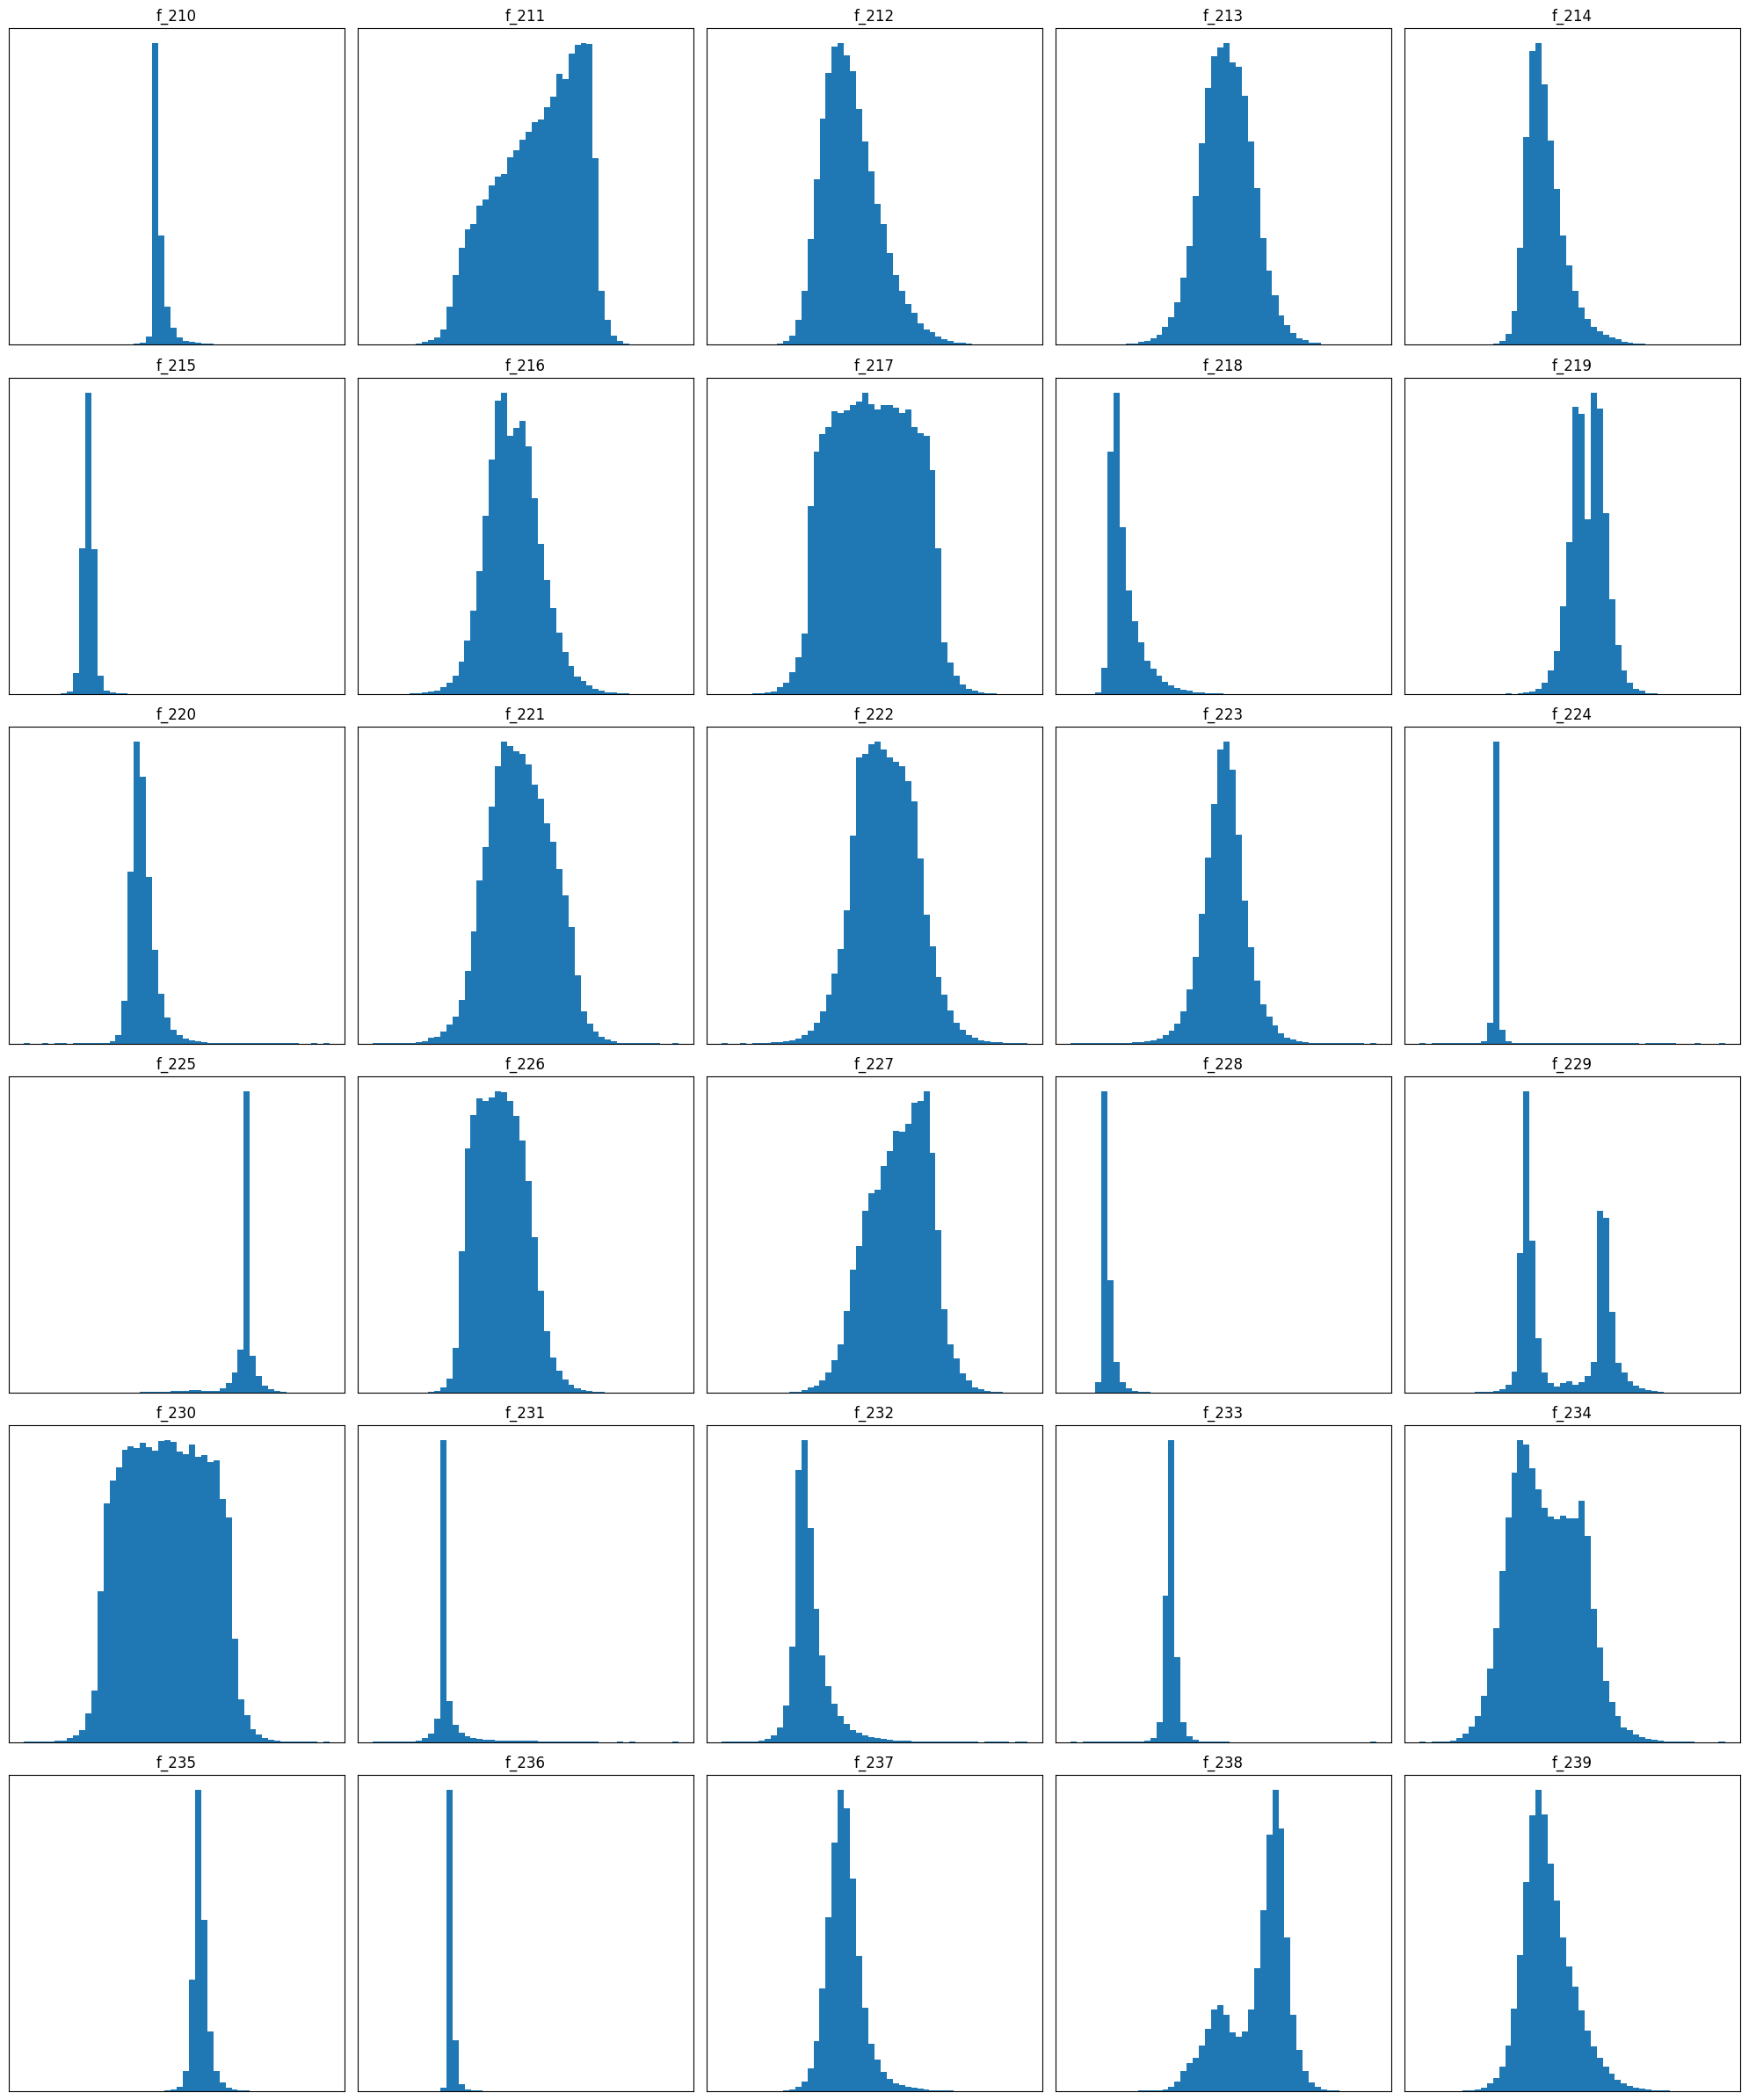

In [21]:
#211~240번째
plot_feature_chunk(df_sample, all_feats, chunk_idx=7)

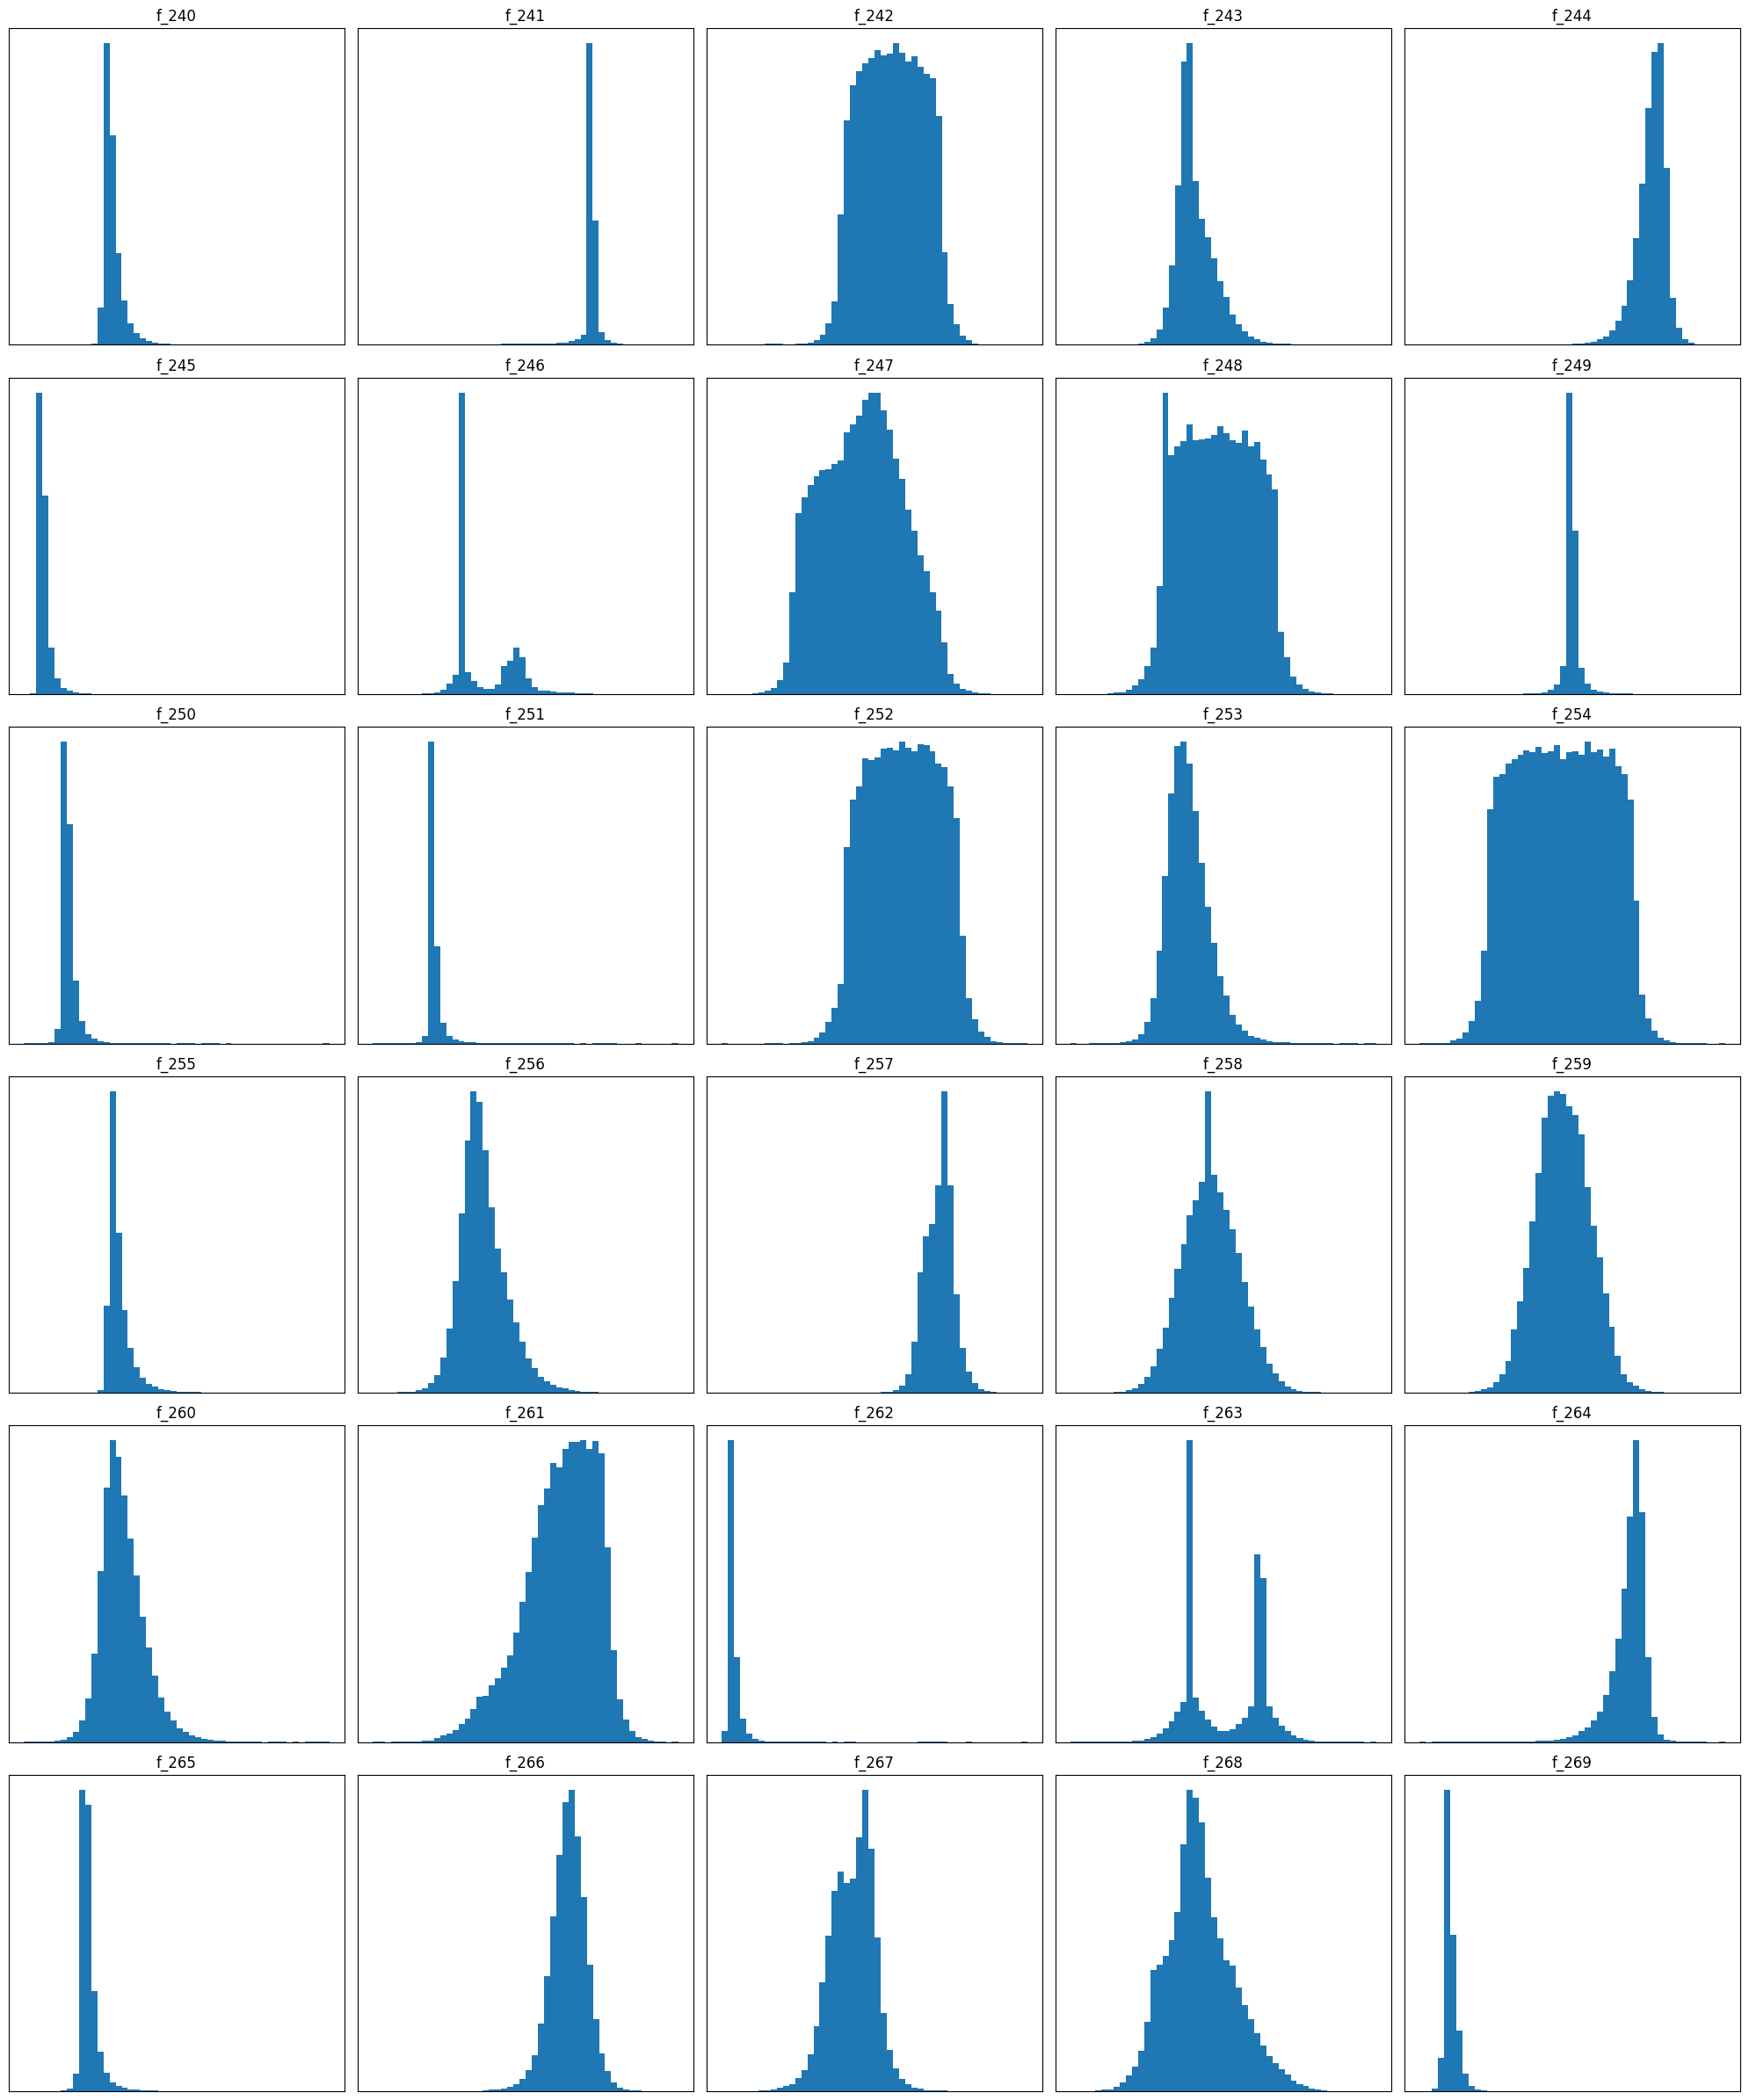

In [22]:
#240~270번째
plot_feature_chunk(df_sample, all_feats, chunk_idx=8)

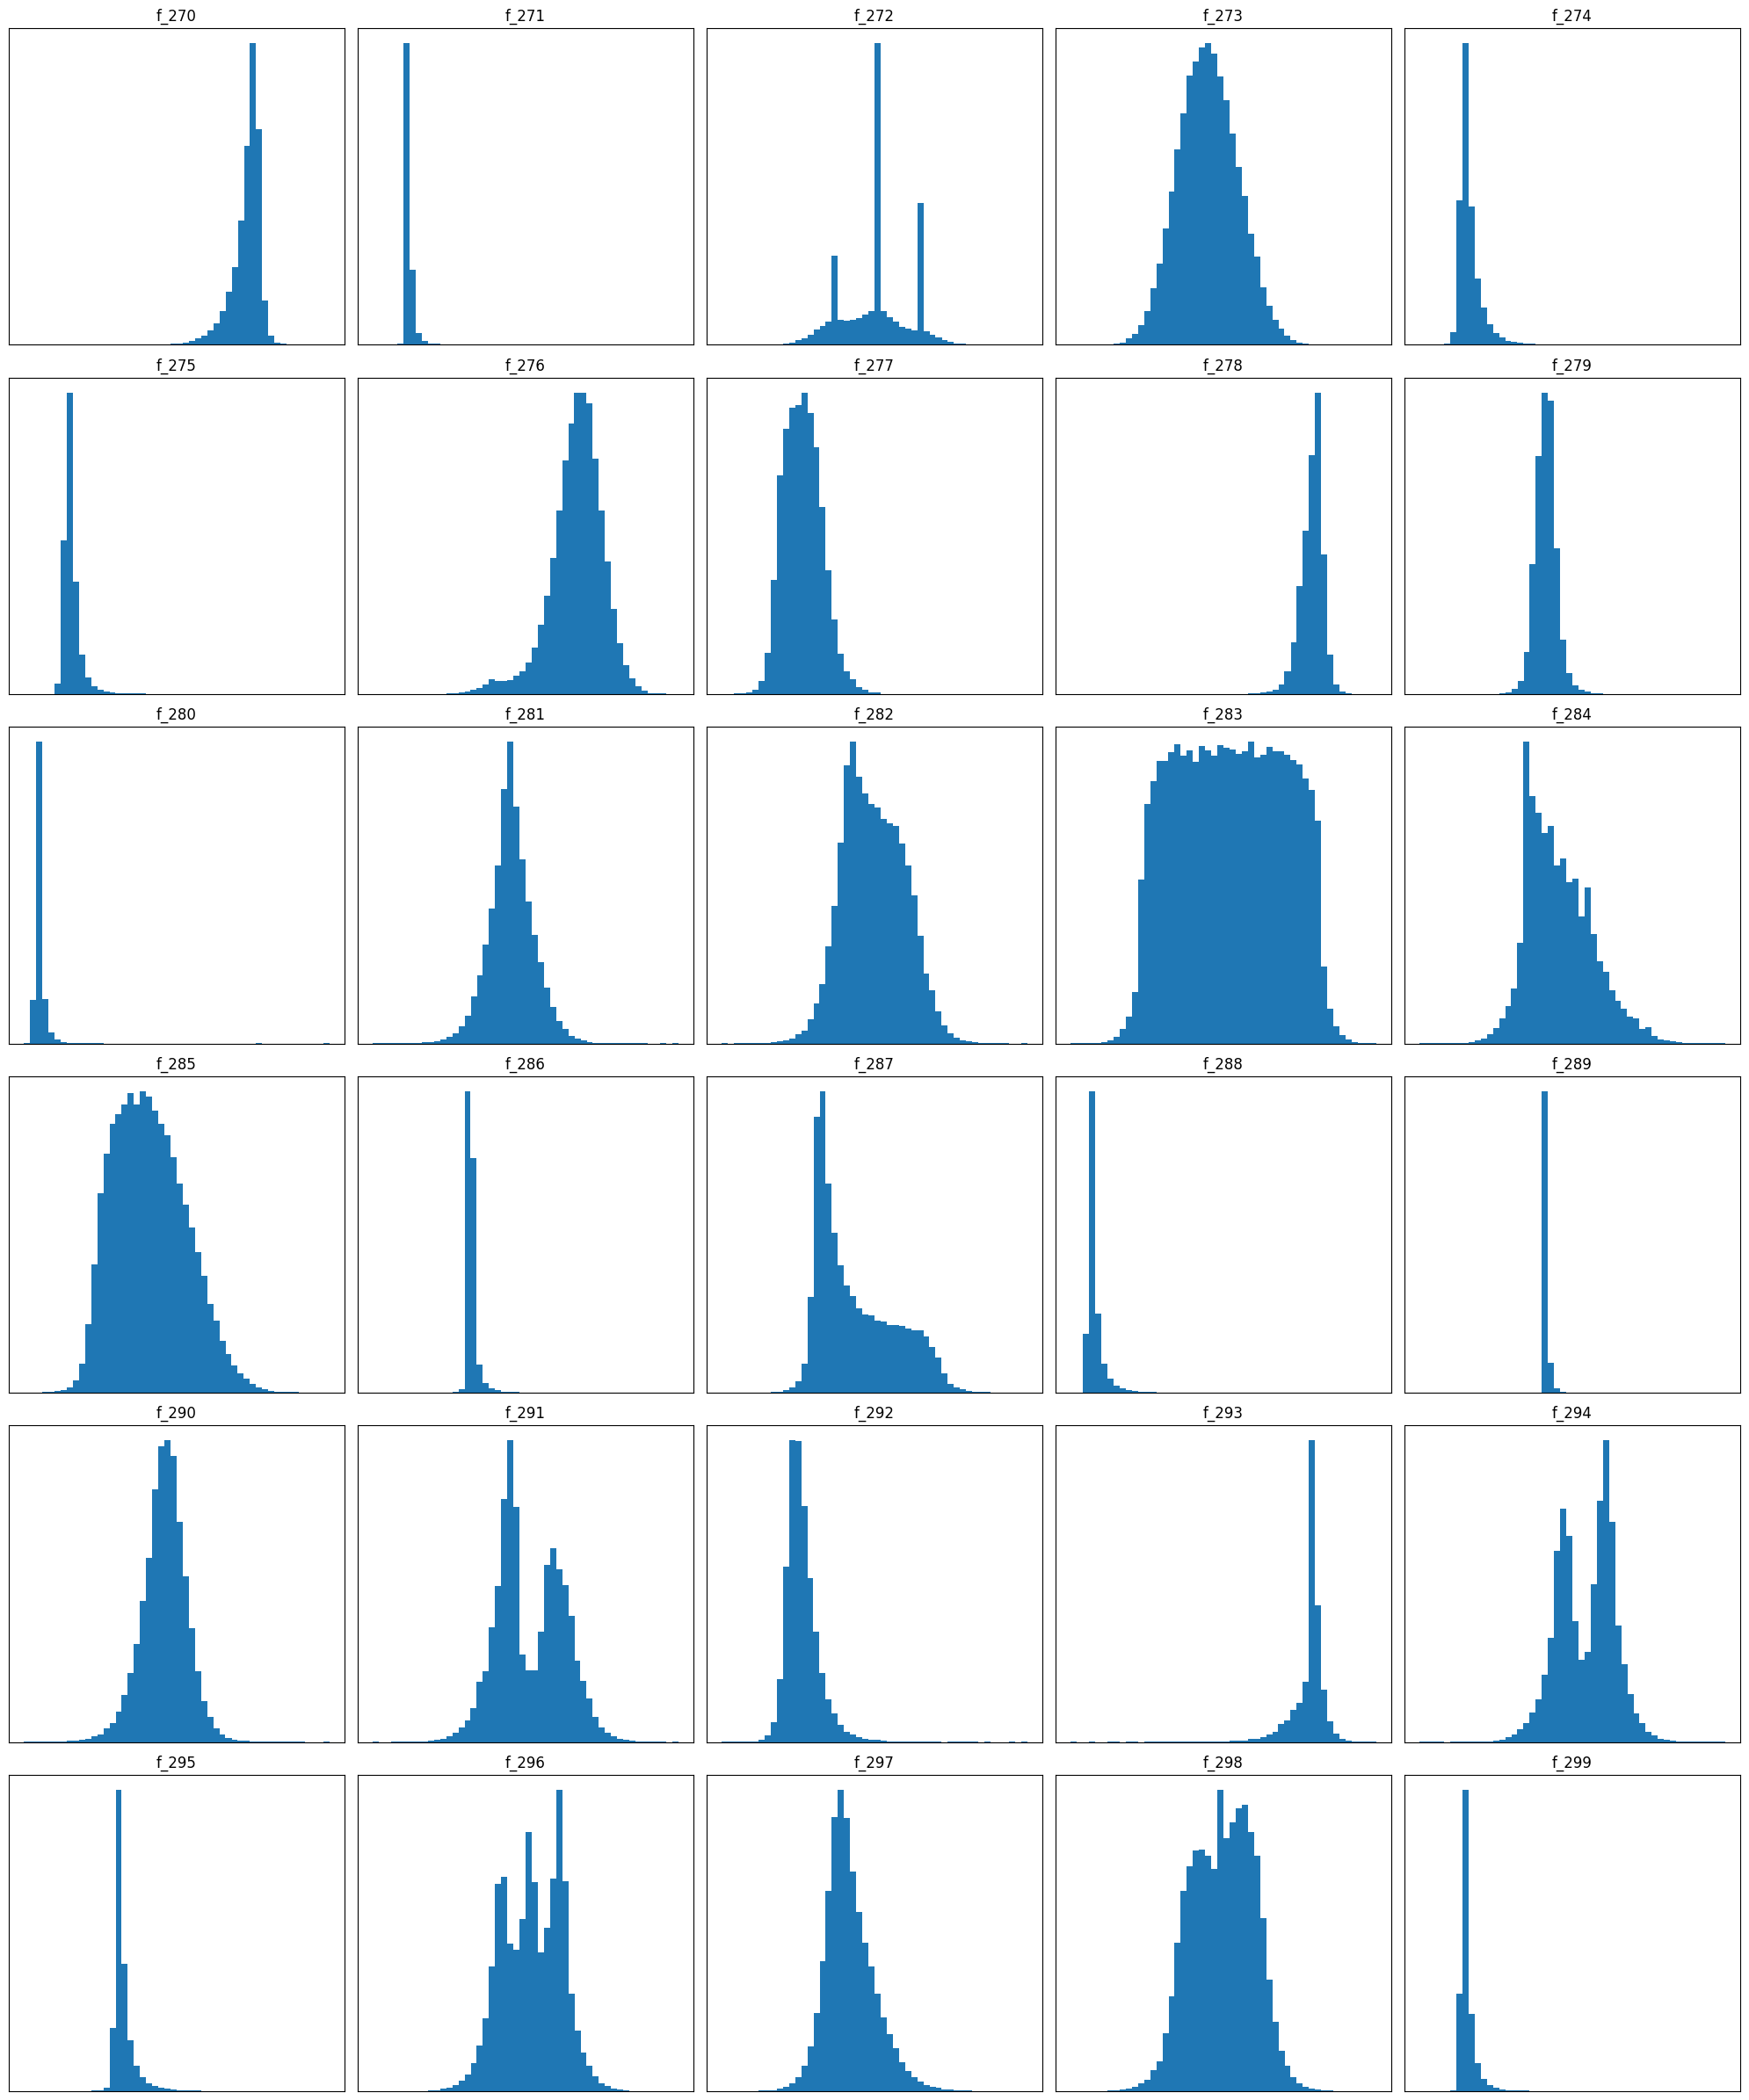

In [23]:
#271~300번째
plot_feature_chunk(df_sample, all_feats, chunk_idx=9)

In [24]:
# 1.1 전체 피처와 타깃의 상관계수 계산
corrs = df_sample.corrwith(df_sample['target']).abs().sort_values(ascending=False)

# 1.2 타깃(target)을 제외한 상위 k개
k = 100
topk = corrs.index.drop('target')[ : k].tolist()
display("Top-k features:", topk)

'Top-k features:'

['f_231',
 'f_250',
 'f_65',
 'f_265',
 'f_71',
 'f_119',
 'f_197',
 'f_83',
 'f_179',
 'f_280',
 'f_270',
 'f_15',
 'f_255',
 'f_155',
 'f_25',
 'f_172',
 'f_286',
 'f_257',
 'f_118',
 'f_76',
 'f_225',
 'f_190',
 'f_150',
 'f_165',
 'f_212',
 'f_92',
 'f_247',
 'f_185',
 'f_137',
 'f_237',
 'f_297',
 'f_273',
 'f_80',
 'f_243',
 'f_168',
 'f_100',
 'f_146',
 'f_268',
 'f_21',
 'f_58',
 'f_264',
 'f_226',
 'f_187',
 'f_216',
 'f_106',
 'f_42',
 'f_214',
 'f_78',
 'f_113',
 'f_232',
 'f_277',
 'f_135',
 'f_79',
 'f_233',
 'f_193',
 'f_41',
 'f_33',
 'f_169',
 'f_77',
 'f_93',
 'f_207',
 'f_16',
 'f_91',
 'f_194',
 'f_271',
 'f_52',
 'f_3',
 'f_239',
 'f_44',
 'f_246',
 'f_17',
 'f_167',
 'f_153',
 'f_174',
 'f_210',
 'f_145',
 'f_173',
 'f_90',
 'f_251',
 'f_295',
 'f_184',
 'f_5',
 'f_116',
 'f_160',
 'f_82',
 'f_238',
 'f_281',
 'f_31',
 'f_47',
 'f_163',
 'f_136',
 'f_206',
 'f_134',
 'f_162',
 'f_188',
 'f_256',
 'f_85',
 'f_88',
 'f_72',
 'f_68']

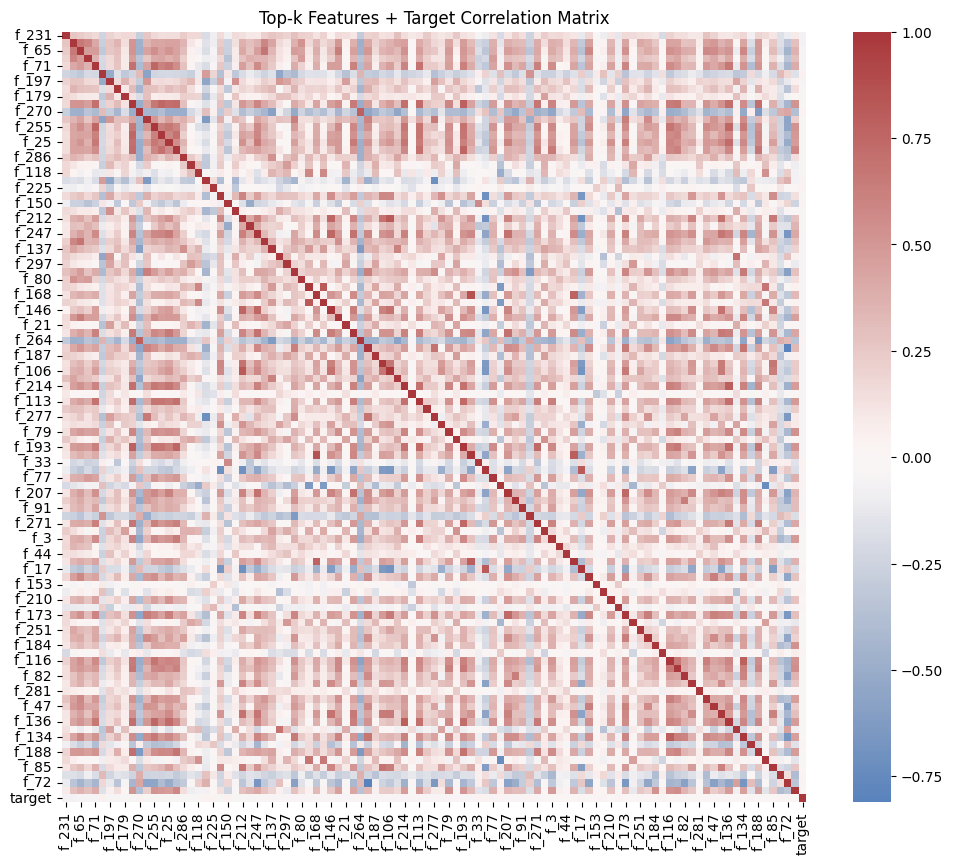

In [25]:
#2) 상관계수 히트맵 한눈에 보기
sub = df_sample[topk + ['target']]  # Top-k + target
plt.figure(figsize=(12,10))
sns.heatmap(sub.corr(),
            annot=False,       # 숫자 대신 색으로만
            cmap='vlag',       # 파랑↔빨강
            center=0,
            fmt=".2f")
plt.title("Top-k Features + Target Correlation Matrix")
plt.show()

In [26]:
# 1) 파라미터 설정
k = 100
chunk_size = 20
vif_threshold = 10.0   # VIF 기준치 (필요에 따라 조정)
df_work = df_sample       # 이미 샘플링된 DataFrame

# 2) Corr 상위 k개 피처 추출
corrs = df_work.corrwith(df_work['target']).abs().sort_values(ascending=False)
top_feats = corrs.index.drop('target')[:k].tolist()

# 3) 청크 단위로 VIF 계산 및 제거
remaining = top_feats.copy()
for chunk_idx in range((k + chunk_size - 1) // chunk_size):
    # 청크 피처 리스트
    chunk_feats = remaining[chunk_idx*chunk_size : (chunk_idx+1)*chunk_size]
    if not chunk_feats:
        break

    # VIF 계산용 배열 준비
    X = df_work[chunk_feats].fillna(0).astype(float).values
    vif_vals = [variance_inflation_factor(X, i)
                for i in range(X.shape[1])]

    # 결과 DataFrame
    vif_df = pd.DataFrame({'feature': chunk_feats, 'VIF': vif_vals})
    vif_df = vif_df.sort_values('VIF', ascending=False).reset_index(drop=True)

    print(f"\n--- Chunk {chunk_idx+1} ({chunk_feats[0]} ~ {chunk_feats[-1]}) VIF Top5 ---")
    display(vif_df.head())

    # 4) 제거할 피처 결정 (예: VIF > threshold)
    drop_feats = vif_df.loc[vif_df['VIF'] > vif_threshold, 'feature'].tolist()

    # 5) remaining에서 제거
    for f in drop_feats:
        remaining.remove(f)

print("\n최종 남은 피처 개수:", len(remaining))
print("=>", remaining)


--- Chunk 1 (f_231 ~ f_76) VIF Top5 ---


,feature,VIF
0,f_280,4.052976
1,f_255,3.161357
2,f_71,2.881857
3,f_15,2.815406
4,f_155,2.740615



--- Chunk 2 (f_225 ~ f_58) VIF Top5 ---


,feature,VIF
0,f_146,4.038579
1,f_247,3.807115
2,f_243,3.162155
3,f_100,3.133260
4,f_212,3.061057



--- Chunk 3 (f_264 ~ f_93) VIF Top5 ---


,feature,VIF
0,f_226,3.102003
1,f_193,3.016599
2,f_113,2.700156
3,f_214,2.664191
4,f_106,2.468573



--- Chunk 4 (f_207 ~ f_295) VIF Top5 ---


,feature,VIF
0,f_173,3.651713
1,f_207,2.820109
2,f_295,2.047851
3,f_271,2.004256
4,f_167,1.894704



--- Chunk 5 (f_184 ~ f_68) VIF Top5 ---


,feature,VIF
0,f_134,4.513231
1,f_116,3.751621
2,f_72,2.981545
3,f_136,2.457877
4,f_163,2.300230



최종 남은 피처 개수: 100
=> ['f_231', 'f_250', 'f_65', 'f_265', 'f_71', 'f_119', 'f_197', 'f_83', 'f_179', 'f_280', 'f_270', 'f_15', 'f_255', 'f_155', 'f_25', 'f_172', 'f_286', 'f_257', 'f_118', 'f_76', 'f_225', 'f_190', 'f_150', 'f_165', 'f_212', 'f_92', 'f_247', 'f_185', 'f_137', 'f_237', 'f_297', 'f_273', 'f_80', 'f_243', 'f_168', 'f_100', 'f_146', 'f_268', 'f_21', 'f_58', 'f_264', 'f_226', 'f_187', 'f_216', 'f_106', 'f_42', 'f_214', 'f_78', 'f_113', 'f_232', 'f_277', 'f_135', 'f_79', 'f_233', 'f_193', 'f_41', 'f_33', 'f_169', 'f_77', 'f_93', 'f_207', 'f_16', 'f_91', 'f_194', 'f_271', 'f_52', 'f_3', 'f_239', 'f_44', 'f_246', 'f_17', 'f_167', 'f_153', 'f_174', 'f_210', 'f_145', 'f_173', 'f_90', 'f_251', 'f_295', 'f_184', 'f_5', 'f_116', 'f_160', 'f_82', 'f_238', 'f_281', 'f_31', 'f_47', 'f_163', 'f_136', 'f_206', 'f_134', 'f_162', 'f_188', 'f_256', 'f_85', 'f_88', 'f_72', 'f_68']


Top 20 feature importances:
f_231    0.006027
f_233    0.005099
f_65     0.004594
f_250    0.004548
f_295    0.004544
           ...   
f_150    0.003539
f_126    0.003538
f_75     0.003529
f_196    0.003526
f_241    0.003522
Length: 100, dtype: float32


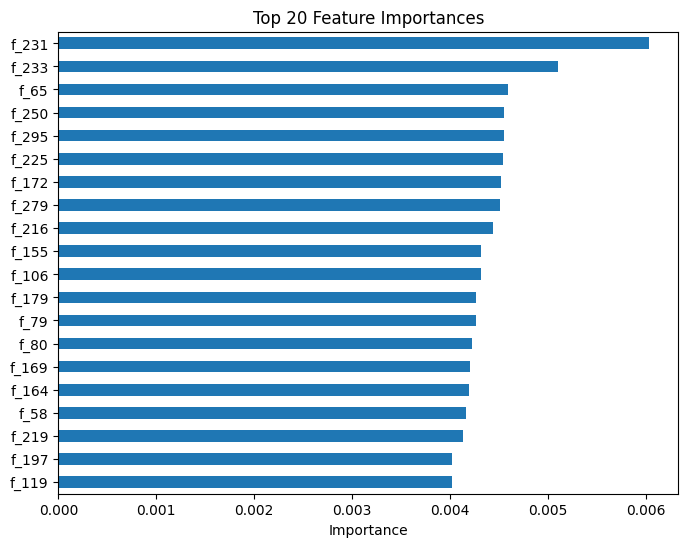

In [27]:
# 1) 데이터 준비
# 0) 5만개 랜덤 샘플 추출
df_small = df_sample.sample(n=50000, random_state=42).reset_index(drop=True)

X = df_small.drop(['row_id', 'time_id', 'investment_id', 'target'], axis=1)
y = df_small['target']

# 2) 모델 정의 & 학습
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    alpha=1.0,
    reg_lambda=1.0,
    random_state=42,
    tree_method='hist',
    verbosity=1
)
model.fit(X, y)

# 3) 피처 중요도 추출
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# 4) 상위 20개 출력
print("Top 20 feature importances:")
print(importances.head(100))

# (선택) 간단한 바 차트로 시각화
plt.figure(figsize=(8,6))
importances.head(20).plot.barh()
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.show()

In [35]:
# 이미 계산해 두신 세 개의 피처 리스트
corr_feats = top_feats          # 상관계수 기반 Top-k
xgb_feats  = importances.index.tolist()[:100]  # XGBoost 중요도 기반 Top-100
vif_feats  = remaining          # VIF 필터링 후 남은 피처

# 1) 세 리스트의 합집합
all_feats = sorted(set(corr_feats + xgb_feats + vif_feats))

# 2) 각 그룹별 컬럼만 뽑기
common_all3 = [f for f in all_feats
               if f in corr_feats and f in xgb_feats and f in vif_feats]

only_corr   = [f for f in all_feats
               if f in corr_feats and f not in xgb_feats and f not in vif_feats]

only_xgb    = [f for f in all_feats
               if f in xgb_feats  and f not in corr_feats and f not in vif_feats]

only_vif    = [f for f in all_feats
               if f in vif_feats  and f not in corr_feats and f not in xgb_feats]

# 결과 출력
print("공통 피처 (3개 모두):", common_all3)
print("오직 상관계수 기반만:", only_corr)
print("오직 XGB 중요도 기반만:", only_xgb)
print("오직 VIF 필터링만:", only_vif)
print("모든 합집합", all_feats,
      len(all_feats))

공통 피처 (3개 모두): ['f_100', 'f_106', 'f_116', 'f_118', 'f_119', 'f_134', 'f_136', 'f_145', 'f_150', 'f_155', 'f_16', 'f_163', 'f_165', 'f_169', 'f_172', 'f_174', 'f_179', 'f_184', 'f_185', 'f_188', 'f_194', 'f_197', 'f_21', 'f_212', 'f_214', 'f_216', 'f_225', 'f_226', 'f_231', 'f_233', 'f_238', 'f_243', 'f_246', 'f_247', 'f_250', 'f_255', 'f_256', 'f_257', 'f_264', 'f_265', 'f_270', 'f_277', 'f_286', 'f_295', 'f_297', 'f_41', 'f_58', 'f_65', 'f_68', 'f_71', 'f_72', 'f_77', 'f_78', 'f_79', 'f_80', 'f_83']
오직 상관계수 기반만: []
오직 XGB 중요도 기반만: ['f_103', 'f_121', 'f_126', 'f_129', 'f_139', 'f_147', 'f_148', 'f_157', 'f_159', 'f_161', 'f_164', 'f_171', 'f_180', 'f_186', 'f_189', 'f_192', 'f_196', 'f_198', 'f_201', 'f_203', 'f_219', 'f_220', 'f_230', 'f_240', 'f_241', 'f_249', 'f_252', 'f_267', 'f_278', 'f_279', 'f_284', 'f_287', 'f_29', 'f_291', 'f_292', 'f_36', 'f_38', 'f_48', 'f_61', 'f_67', 'f_69', 'f_73', 'f_75', 'f_86']
오직 VIF 필터링만: []
모든 합집합 ['f_100', 'f_103', 'f_106', 'f_113', 'f_116', 'f_11

In [38]:
# 1) 전체 DataFrame 로딩 (샘플이 아니라 원본 train_parquet 또는 df_full 을 사용하세요)
# 3) 파일로 저장
# 3) 필요한 컬럼만 추출
df_export = df[['row_id','time_id','investment_id','target'] + all_feats]

# 4) 현재 작업 디렉토리에 저장
output_path = "selected_144_features.csv"
df_export.to_csv(output_path, index=False)

print(f"Done! 파일이 '{output_path}' 로 저장되었습니다.")

Done! 파일이 'selected_144_features.csv' 로 저장되었습니다.
